<center> <h1> Target2 compound filtering into an unbiased dataset relative to source, microscope configuration and well. </h1> </center>

In [1]:
import polars as pl
from data_v2 import get_table
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# 1) Table Creation 

In [2]:
compound = get_table("compound")
well = get_table("well")
plate = get_table("plate")
micro = get_table("microscope_config")
target2 = get_table("target2")
target2_plate = get_table("target2_plate")

In [3]:
# Rename the source 13 into source 7
well = well.with_columns(
    pl.when(pl.col("Metadata_Source").str.contains("_13$"))
    .then(pl.lit("source_7"))
    .otherwise(pl.col("Metadata_Source"))
    .alias("Metadata_Source"))

# Removal of source_9 and source_1.
well = well.filter(pl.col("Metadata_Source").str.contains("_9|_1$") != True)

plate = plate.select(pl.all().exclude("Metadata_Source"))

micro_features = ['Metadata_Source','Metadata_Microscope_Name',
                  'Metadata_Widefield_vs_Confocal',
                  'Metadata_Excitation_Type',
                  'Metadata_Objective_NA',
                  'Metadata_Filter_Configuration']
micro = micro.with_columns(
    ("source_" + pl.col("Metadata_Source").cast(str)).alias("Metadata_Source")).select(
    pl.col(micro_features))


In [4]:
micro = micro.filter(pl.col("Metadata_Source").str.contains("_[19]$|_15$|_13$") != True)
map_micro_ID = micro.select(pl.col("Metadata_Source"),
                            pl.struct(pl.all().exclude("Metadata_Source")).alias("unique"))\
                            .sort(by="unique")\
                            .select(pl.col("Metadata_Source"), pl.col("unique").rle_id().alias("Micro_id"))

micro = micro.join(map_micro_ID,
           on="Metadata_Source",
           how="left")

In [5]:
target2.group_by("InChIKey").agg(pl.all().n_unique()).with_columns(
    pl.sum_horizontal(pl.all().exclude("InChIKey"))).filter(pl.col("sum")>8)

InChIKey,broad_sample,pert_iname,pubchem_cid,target,pert_type,control_type,smiles,InChI,sum
str,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""GJFCONYVAUNLKB…",2,1,2,1,1,1,1,1,10
"""AJVXVYTVAAWZAP…",2,1,2,1,1,1,1,1,10
"""QIHBWVVVRYYYRO…",2,1,2,1,1,1,1,1,10
"""LOUPRKONTZGTKE…",2,2,2,2,1,1,1,1,12
"""UTBOEBCWXGDOGI…",2,1,2,1,1,1,1,1,10


Here we can notice that InChIKey is not a unique identifier. We should remove duplicates to avoid complication later on. 

broad_sample, pubchem_cid can be removed without hesitation (not useful next for mergin etc.) 
pert_iname and target (target can give insight on moa or it can be another way to group sample than moa. and pert_iname is how we're going to merge moa and our table at the end) can still be informative so we should deal with this sample: "LOUPRKONTZGTKE..."

In [6]:
target2.filter(pl.col("InChIKey").str.contains("LOUPRKONTZGTKE"))

broad_sample,InChIKey,pert_iname,pubchem_cid,target,pert_type,control_type,smiles,InChI
str,str,str,i64,str,str,str,str,str
"""BRD-K48278478-…","""LOUPRKONTZGTKE…","""quinine""",94175,"""KCNN4""","""trt""","""NA""","""C=CC1CN2CCC1CC…","""InChI=1S/C20H2…"
"""BRD-K59632282-…","""LOUPRKONTZGTKE…","""quinidine""",441074,"""KCNK1""","""trt""","""NA""","""C=CC1CN2CCC1CC…","""InChI=1S/C20H2…"


When looking at the following website, the InChiKey is supposed to be different: 
* quinidine:
  - [LOUPRKONTZGTKE-WGFDLZGGSA-N](https://webbook.nist.gov/cgi/inchi?ID=C56542) (from webbook chemistry NIST)
  - [LOUPRKONTZGTKE-LHHVKLHASA-N](https://pubchem.ncbi.nlm.nih.gov/compound/Quinidine#section=Crystal-Structures) (from PubChem NIH)
* quinine:
  - [LOUPRKONTZGTKE-UHFFFAOYSA-N](https://webbook.nist.gov/cgi/inchi/InChI%3D1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10-19(22)20(23)16-6-8-21-18-5-4-15(24-2)11-17(16)18/h3-6%2C8%2C11%2C13-14%2C19-20%2C23H%2C1%2C7%2C9-10%2C12H2%2C2H3) (from webbook chemistry NIST)
  - [LOUPRKONTZGTKE-WZBLMQSHSA-N](https://pubchem.ncbi.nlm.nih.gov/compound/Quinine#section=Computed-Descriptors) (from PubChem NIH)

The difference happens to be within the 8 digits which account for the stereochemistry cf [original_paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0068-4/figures/7), for instance: "LHHVKLHA".

Let's see the one chosen in Target2 and the amount of different digits in compound. 

In [7]:
target2.filter(pl.col("InChIKey").str.contains("LOUPRKONTZGTKE")).select(
    pl.col("InChIKey").unique()).to_numpy()

array([['LOUPRKONTZGTKE-UHFFFAOYSA-N']], dtype=object)

In [8]:
compound.select(pl.col("Metadata_InChIKey").str.extract("\w+-(\w{8}SA)-").unique())

Metadata_InChIKey
str
"""QOPSANPBSA"""
"""UHFFFAOYSA"""
null


Therefore: quinine is the valid one to keep. 

In [9]:
target2 = target2.filter(pl.col("broad_sample").str.contains("BRD-K59632282-") != True)

In [10]:
target2 = target2.select(pl.all().exclude(["broad_sample", "pubchem_cid"])).unique()

In [11]:
merge_table = compound.join(well, on=pl.col("Metadata_JCP2022"), how="inner")\
.join(plate, on=pl.col("Metadata_Plate"), how="inner")\
.join(micro, on=pl.col("Metadata_Source"), how="inner")\
.join(target2,left_on=pl.col("Metadata_InChIKey"), right_on=pl.col("InChIKey"), how="inner")

merge_table = merge_table.unique()


In [12]:
merge_table.shape

(212865, 20)

In [13]:
merge_table.select(pl.all().n_unique())

Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,Metadata_Excitation_Type,Metadata_Objective_NA,Metadata_Filter_Configuration,Micro_id,pert_iname,target,pert_type,control_type,smiles,InChI
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
302,302,302,9,2174,384,126,8,5,2,2,2,6,7,302,161,2,5,302,302


# 2) Analysis of the Table distribution of compounds among sources or well. 

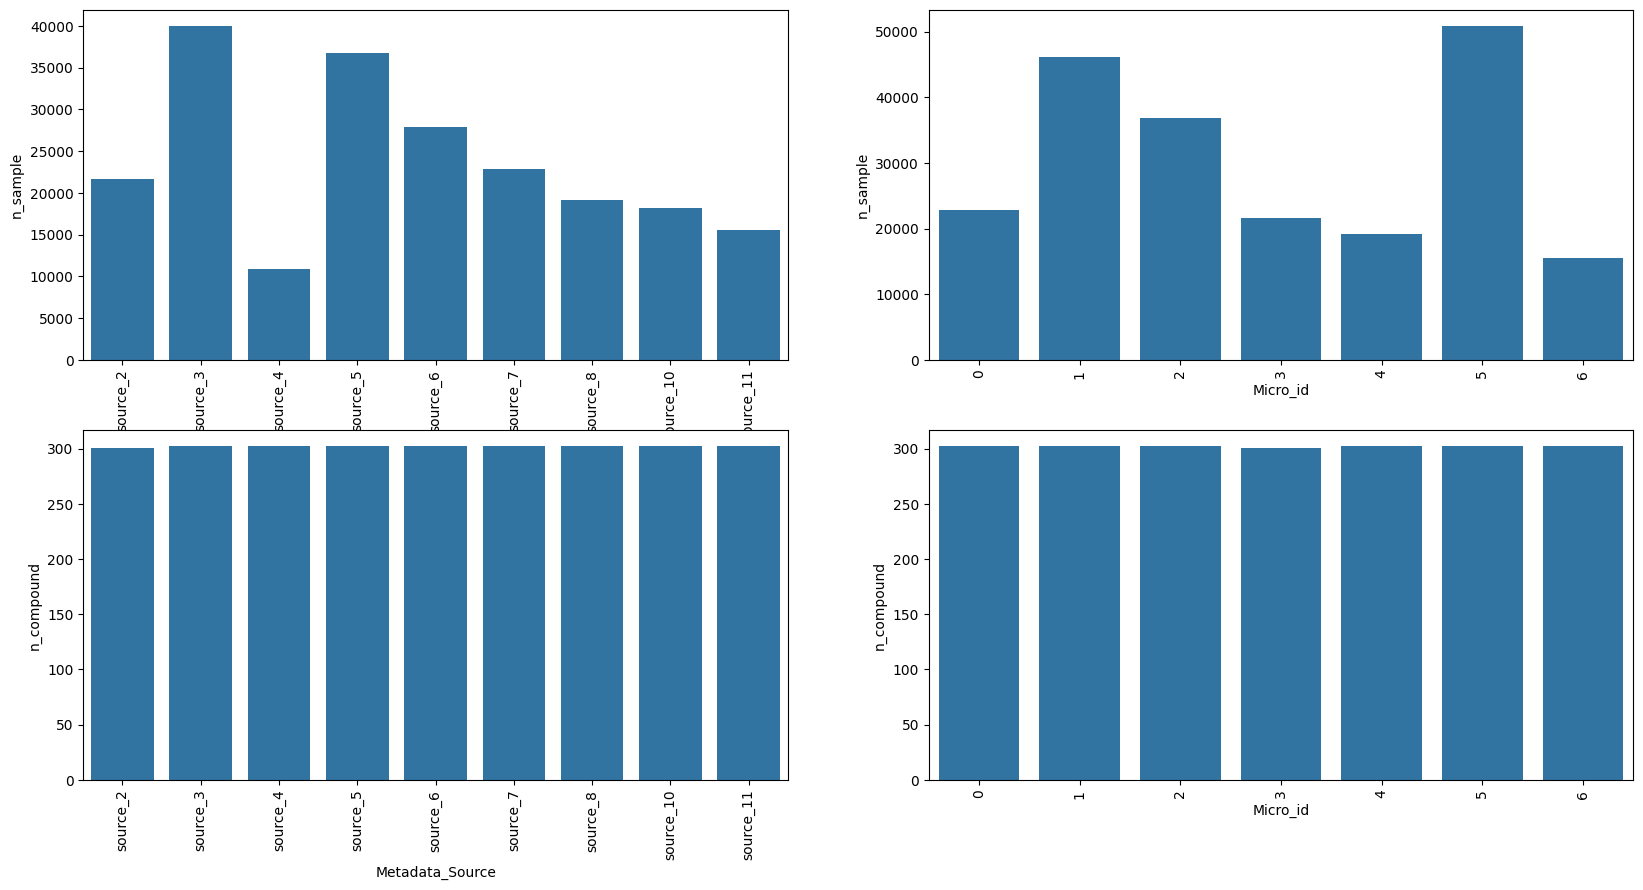

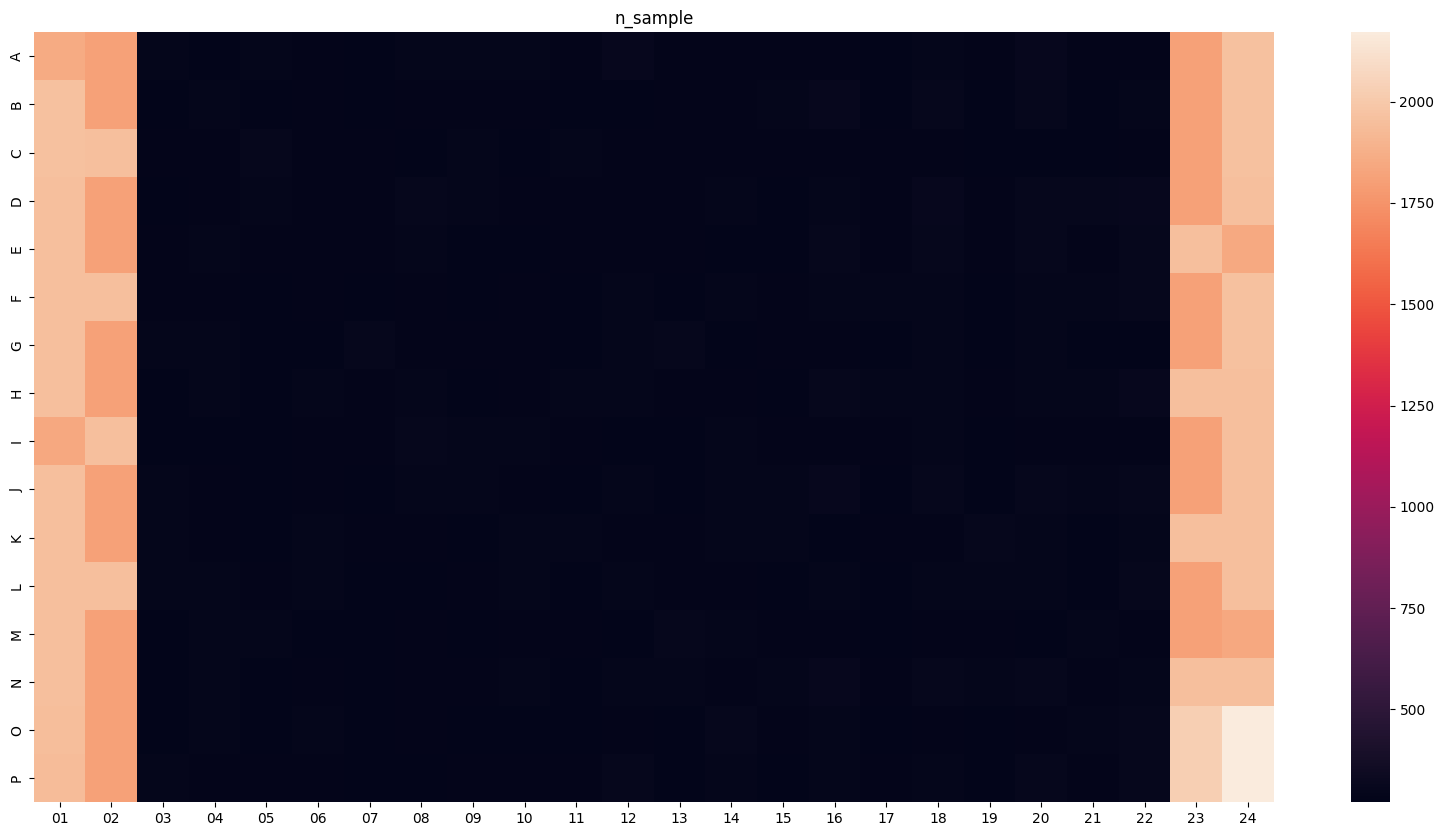

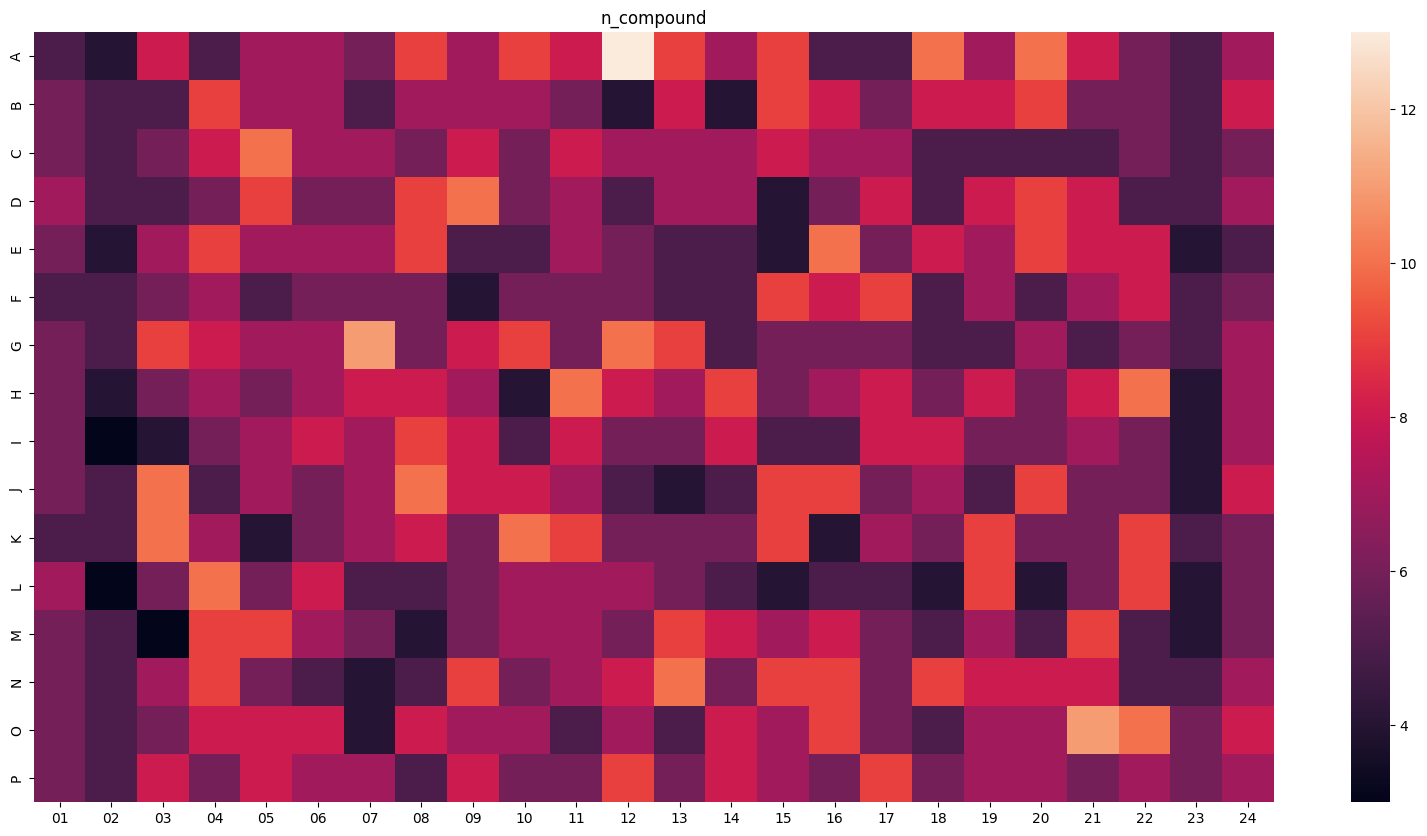

In [644]:
def show_distribution(filter_merge_table):
    info_per_source = (filter_merge_table.group_by("Metadata_Source")
                         .agg(
                             pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
                             pl.col("Metadata_JCP2022").count().alias("n_sample"))
                       .sort(by=pl.col("Metadata_Source").str.extract("\D+_(\d+)").cast(pl.Int16)))
     
    info_per_micro = (filter_merge_table.group_by("Micro_id")
                         .agg(
                             pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
                             pl.col("Metadata_JCP2022").count().alias("n_sample"))
                       .sort(by="Micro_id"))
    

    info_per_well = (filter_merge_table.group_by("Metadata_Well")
                     .agg(
                         pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
                         pl.col("Metadata_JCP2022").count().alias("n_sample"))
                   .sort(by="Metadata_Well").select(
                       pl.col("Metadata_Well").str.extract("(\D+)").alias("Well_letter"),
                       pl.col("Metadata_Well").str.extract("\D+(\d+)").alias("Well_numb"),
                       pl.col("n_compound", "n_sample")))

    
    fig, axes = plt.subplots(2,2, figsize=(20, 10))
    info_per_group = [info_per_source, info_per_micro]
    group = ["Metadata_Source", "Micro_id"]
    info = ["n_sample", "n_compound"]
    for i in range(2):
        for j in range(2):
            sns.barplot(info_per_group[j],
                       x=group[j],
                       y=info[i],
                       ax=axes[i][j])
            axes[i][j].tick_params(axis='x', rotation=90)


    sample_well_map = info_per_well.pivot(index="Well_letter",
                                    columns="Well_numb",
                                    values="n_sample")
    compound_well_map = info_per_well.pivot(index="Well_letter",
                                    columns="Well_numb",
                                    values="n_compound")
    
    
    fig2, ax2 = plt.subplots(1, figsize=(20,10))
    sns.heatmap(sample_well_map.select(pl.all().exclude("Well_letter")),
                ax=ax2)
    ax2.set_xticklabels(sample_well_map.columns[1:])
    ax2.set_yticklabels(sample_well_map.select(pl.col("Well_letter")).to_numpy().reshape(-1))
    ax2.set_title("n_sample")

    
    fig3, ax3 = plt.subplots(1, figsize=(20,10))
    sns.heatmap(compound_well_map.select(pl.all().exclude("Well_letter")),
                ax=ax3)
    ax3.set_xticklabels(compound_well_map.columns[1:])
    ax3.set_yticklabels(compound_well_map.select(pl.col("Well_letter")).to_numpy().reshape(-1))
    ax3.set_title("n_compound")
show_distribution(merge_table)

In [645]:
merge_table.group_by("Metadata_Source").agg(pl.col("Metadata_JCP2022").n_unique())

Metadata_Source,Metadata_JCP2022
str,u32
"""source_2""",301
"""source_8""",302
"""source_3""",302
"""source_4""",302
"""source_11""",302
"""source_6""",302
"""source_7""",302
"""source_10""",302
"""source_5""",302


* The goal is to downsample each source so it is more alike to source 4. But we cannot remove sample randomly without risking removing some interesting compound of target2. Indeed in target2 there are poscon or negcon that might have been overused in some sources so we should downsampling from those negcon and poscon. There should be easy to identify as they should have been overused.
* There is one compound that has not been used in all sources so let's remove it as well. 

# 3) Table Filtering
### a) Removal of the compounds not in all sources.

In [646]:
merge_table = (merge_table.filter(
    pl.col("Metadata_JCP2022").is_in((merge_table.group_by("Metadata_JCP2022")
                                      .agg(pl.col("Metadata_Source").n_unique()).
                                      filter(pl.col("Metadata_Source") < 9)
                                      .select("Metadata_JCP2022")).to_series()) == False))

### b) Identification of the compounds to downsample. 

In [647]:
compounds_info = (merge_table.group_by("Metadata_JCP2022")
                  .agg(pl.col("Metadata_InChIKey").count().alias("Sample_count"),
                       pl.col("Metadata_Source", "Metadata_Well", "Micro_id")
                       .n_unique().name.prefix("Unique_"))
                       )

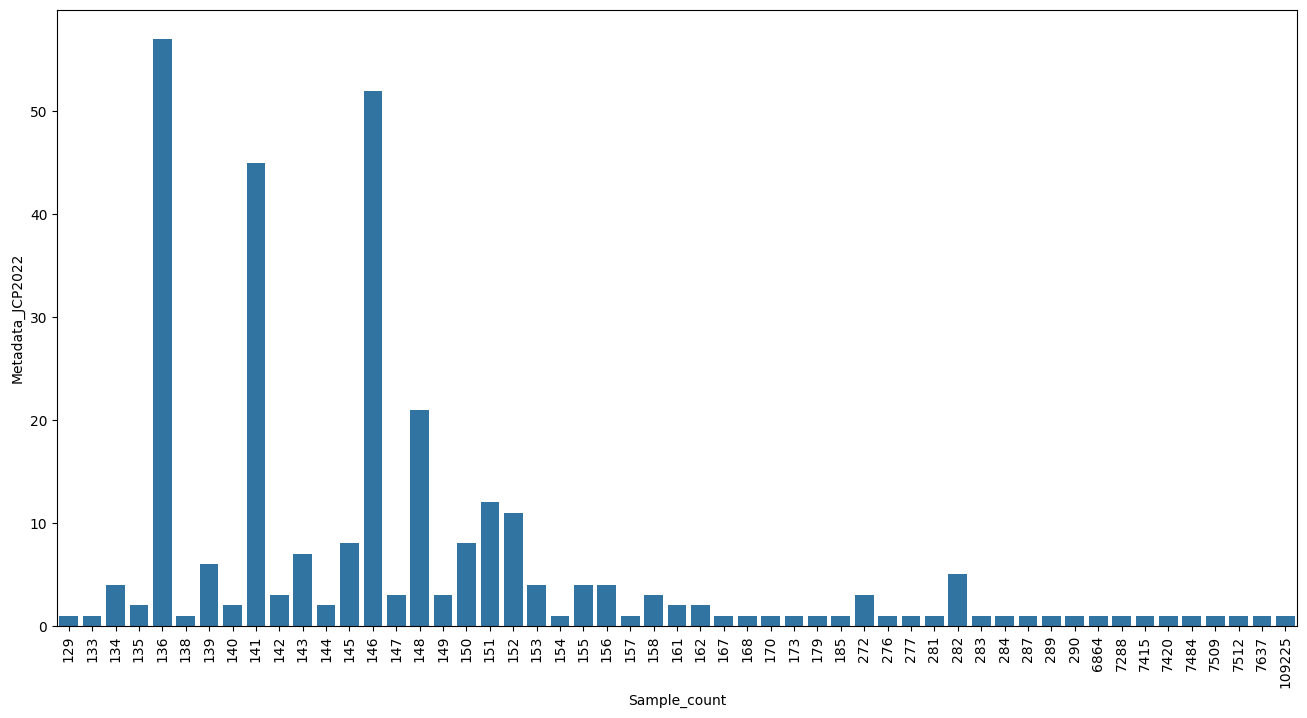

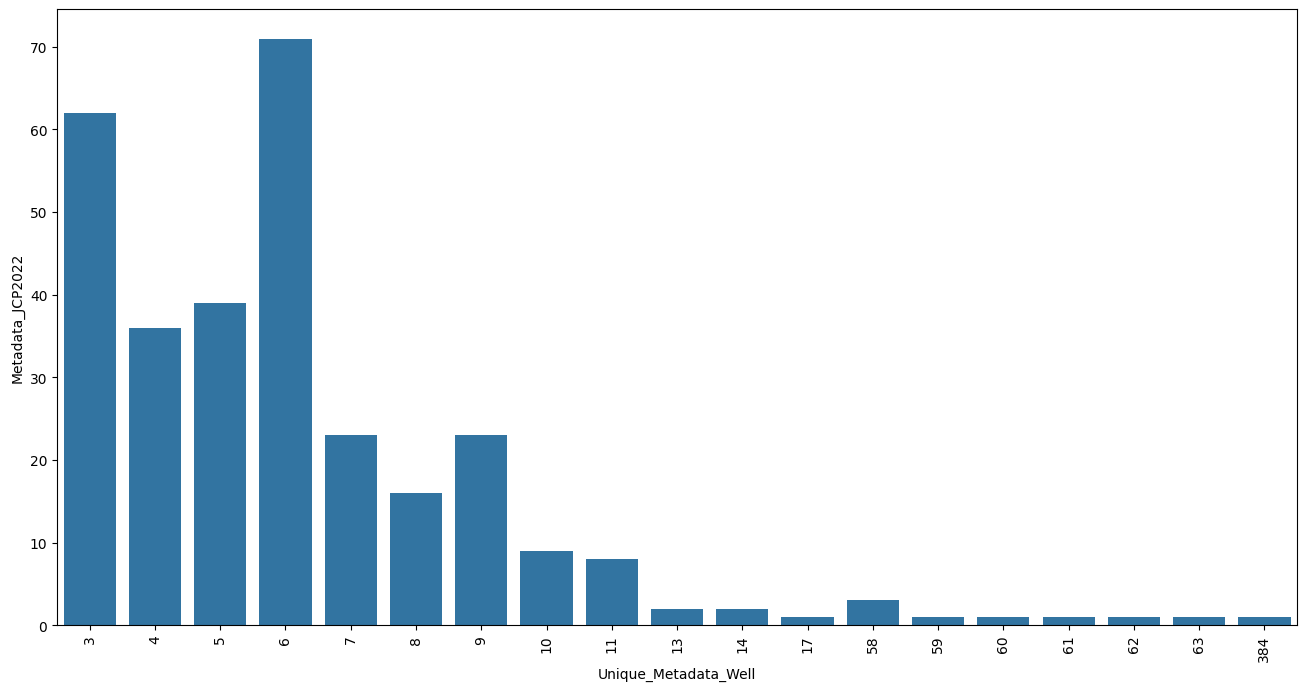

In [648]:
fig, ax1 = plt.subplots(1, figsize=(16,8))

df = (compounds_info.group_by("Sample_count")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Sample_count"))

sns.barplot(df,
            x="Sample_count",
            y="Metadata_JCP2022",
            ax=ax1)
ax1.tick_params(axis='x', rotation=90)

fig, ax2 = plt.subplots(1, figsize=(16,8))

df2 = (compounds_info.group_by("Unique_Metadata_Well")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Unique_Metadata_Well"))

sns.barplot(df2,
            x="Unique_Metadata_Well",
            y="Metadata_JCP2022",
            ax=ax2)
ax2.tick_params(axis='x', rotation=90)

4 group can be identified looking at the count of sample per compounds. 
* Compounds with a usage < 200 samples.
* Compounds with a usage between 200 and 300 samples.
* Compounds with a usage between 6000 and 8000 samples: This is usually control.
* Compounds with a usage exceptionnally high, more than 8000 usage: This must be DMSO.  

Each category should be down sample seperately. 

### c) Down Sampling of the control

In [649]:
seed = 42

In [650]:
controle_name = (compounds_info
.filter(pl.col("Sample_count") > 8000).select("Metadata_JCP2022")).to_series()

trt_name = (compounds_info
.filter(pl.col("Sample_count") < 200).select("Metadata_JCP2022")).to_series()

between1_name = (compounds_info
.filter(pl.col("Sample_count").is_between(200, 300)).select("Metadata_JCP2022")).to_series()

between2_name = (compounds_info
.filter(pl.col("Sample_count").is_between(6000, 8000)).select("Metadata_JCP2022")).to_series()

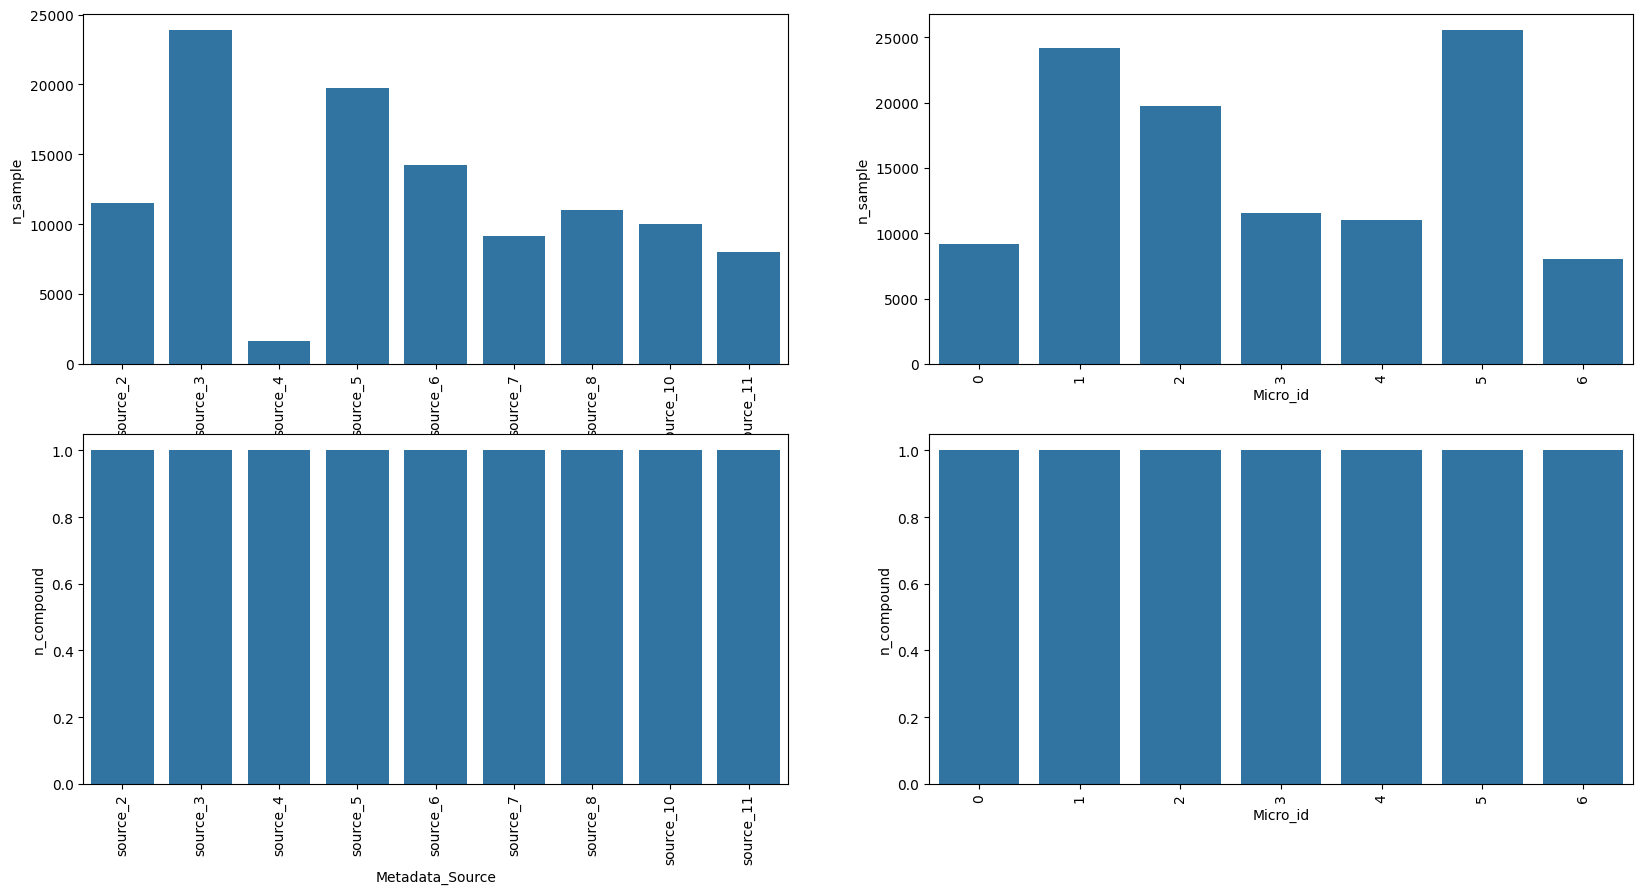

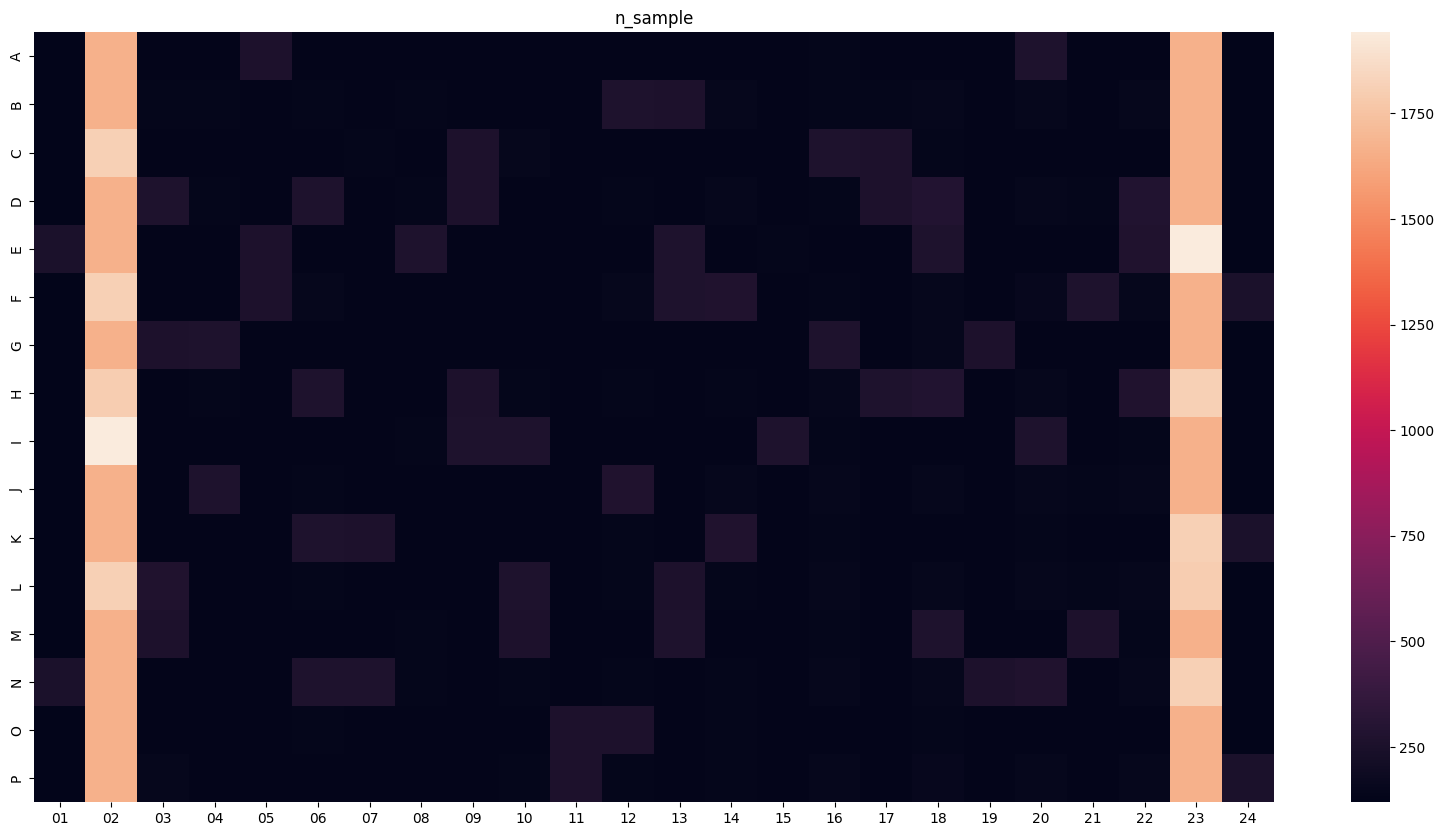

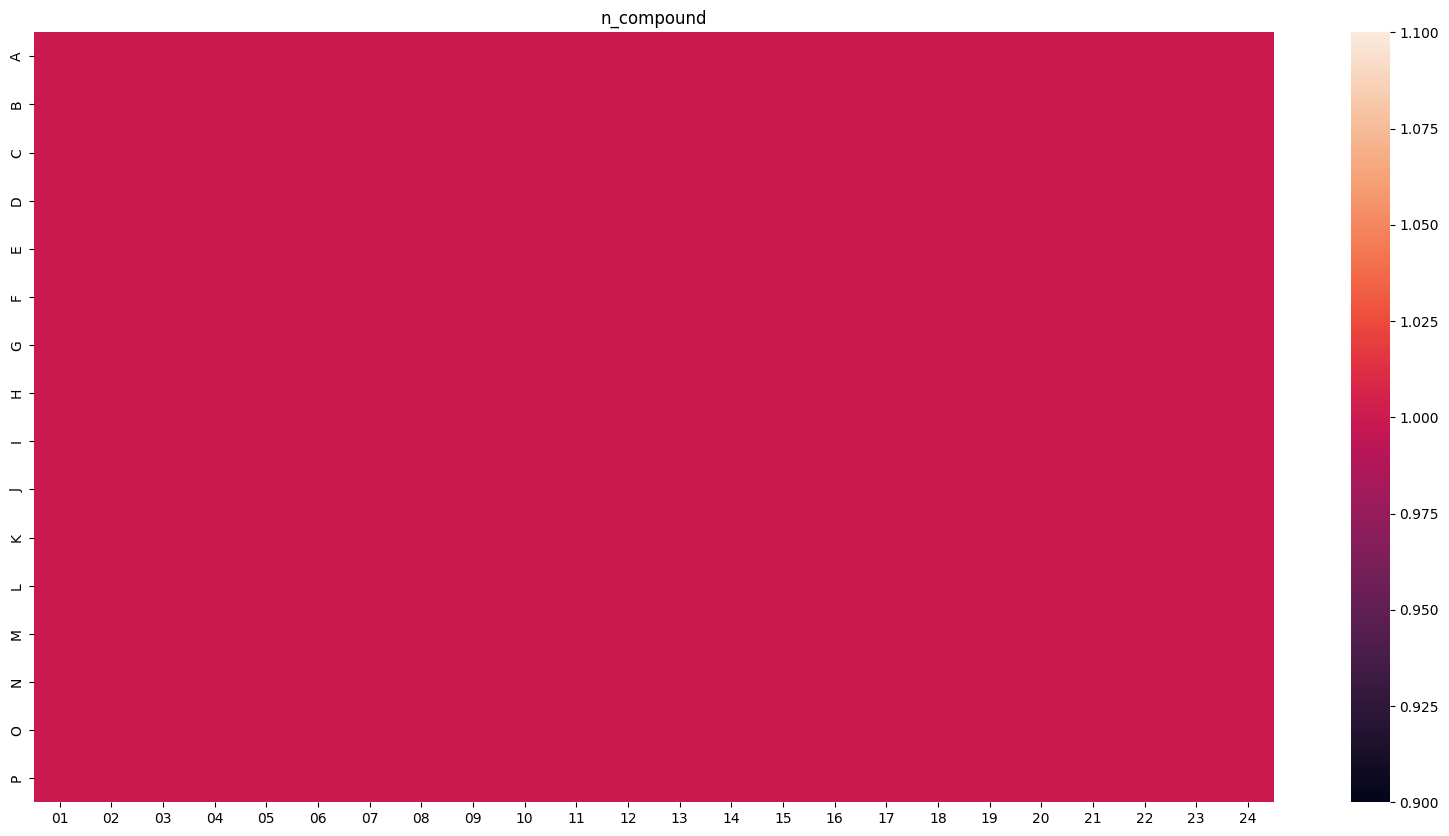

In [651]:
# First see how to downsample
show_distribution(merge_table.filter(
    pl.col("Metadata_JCP2022").is_in(
        controle_name)))

In [652]:
#For every source except for the source 4, down sampling to only 2800 samples 
merge_table_control = (merge_table.filter(
    pl.col("Metadata_JCP2022").is_in(controle_name))
.filter(
    pl.col("Metadata_Source").str.contains("_4$") != True)
.sort(by=["Metadata_Source", "Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"]))

merge_table_control_keep = (merge_table_control.group_by("Metadata_Source")
     .agg(pl.struct(pl.col("Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"))
          .sort()
          .sample(1660, seed=seed))
     .sort(by="Metadata_Source")
    .explode("Metadata_JCP2022")
    .unnest("Metadata_JCP2022"))

In [653]:
merge_table_control = (merge_table_control.join(merge_table_control_keep,
                         on=["Metadata_Source","Metadata_JCP2022", "Metadata_Plate", 
                             "Metadata_Well", "Metadata_Batch"],
                         how="inner")
                       .unique()
                       .join((merge_table.filter(
                           pl.col("Metadata_JCP2022").is_in(controle_name))
                              .filter(
                                  pl.col("Metadata_Source").str.contains("_4$"))),
                             on=merge_table.columns,
                             how="outer")).unique()

### d) Down Sampling of the between1 and between2 category

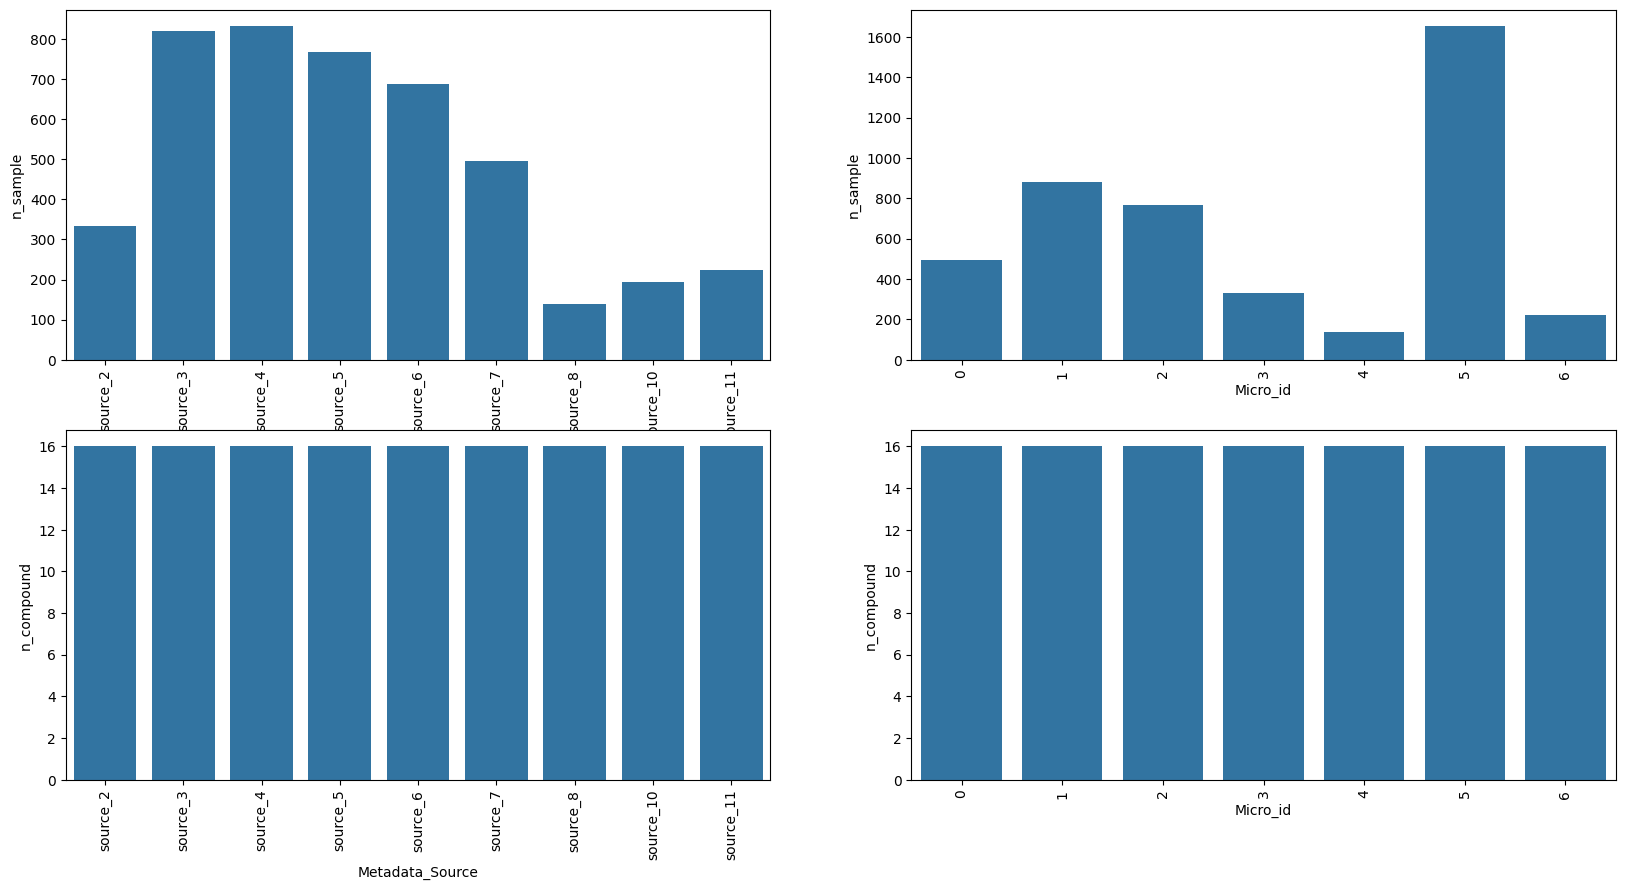

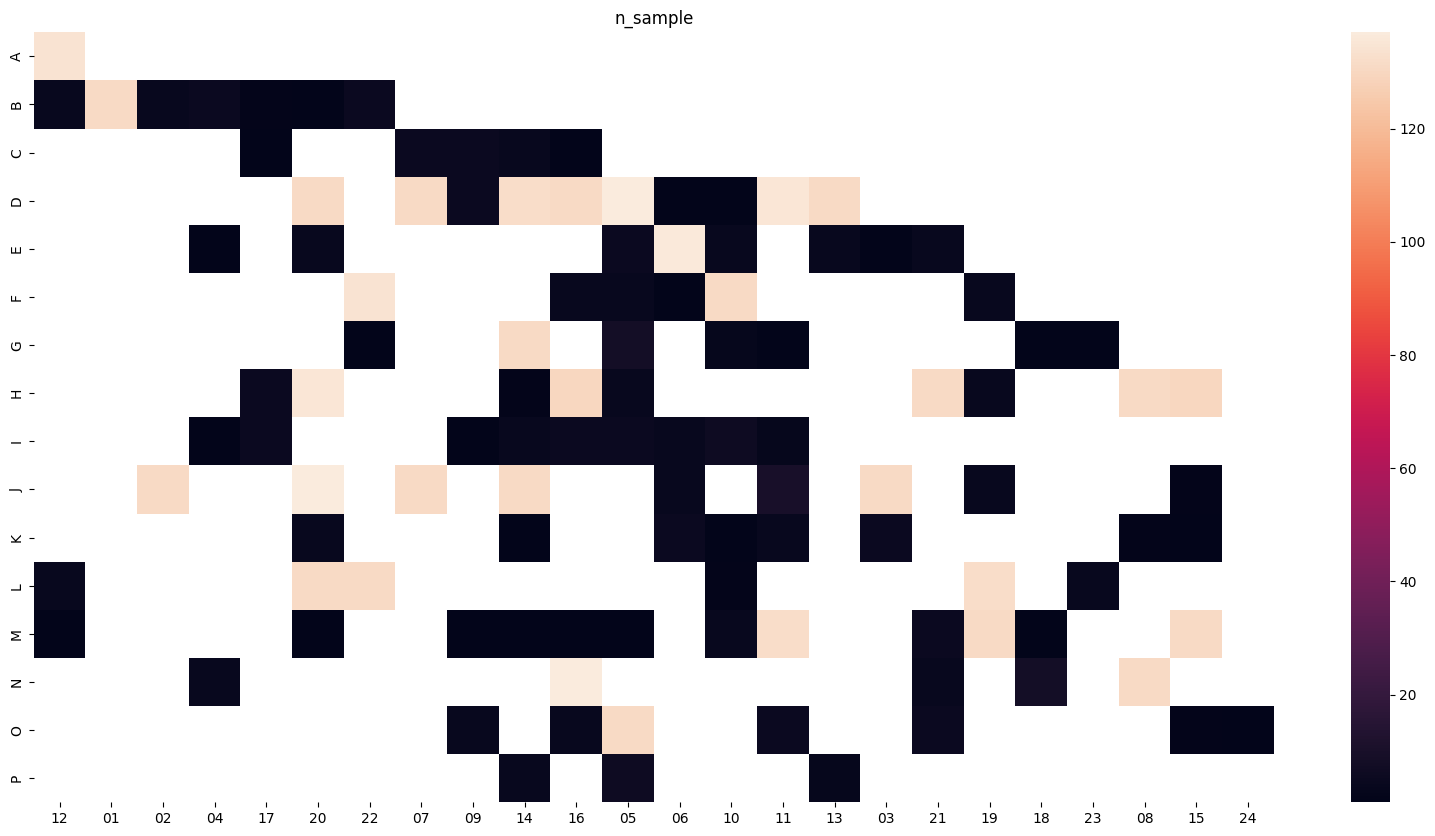

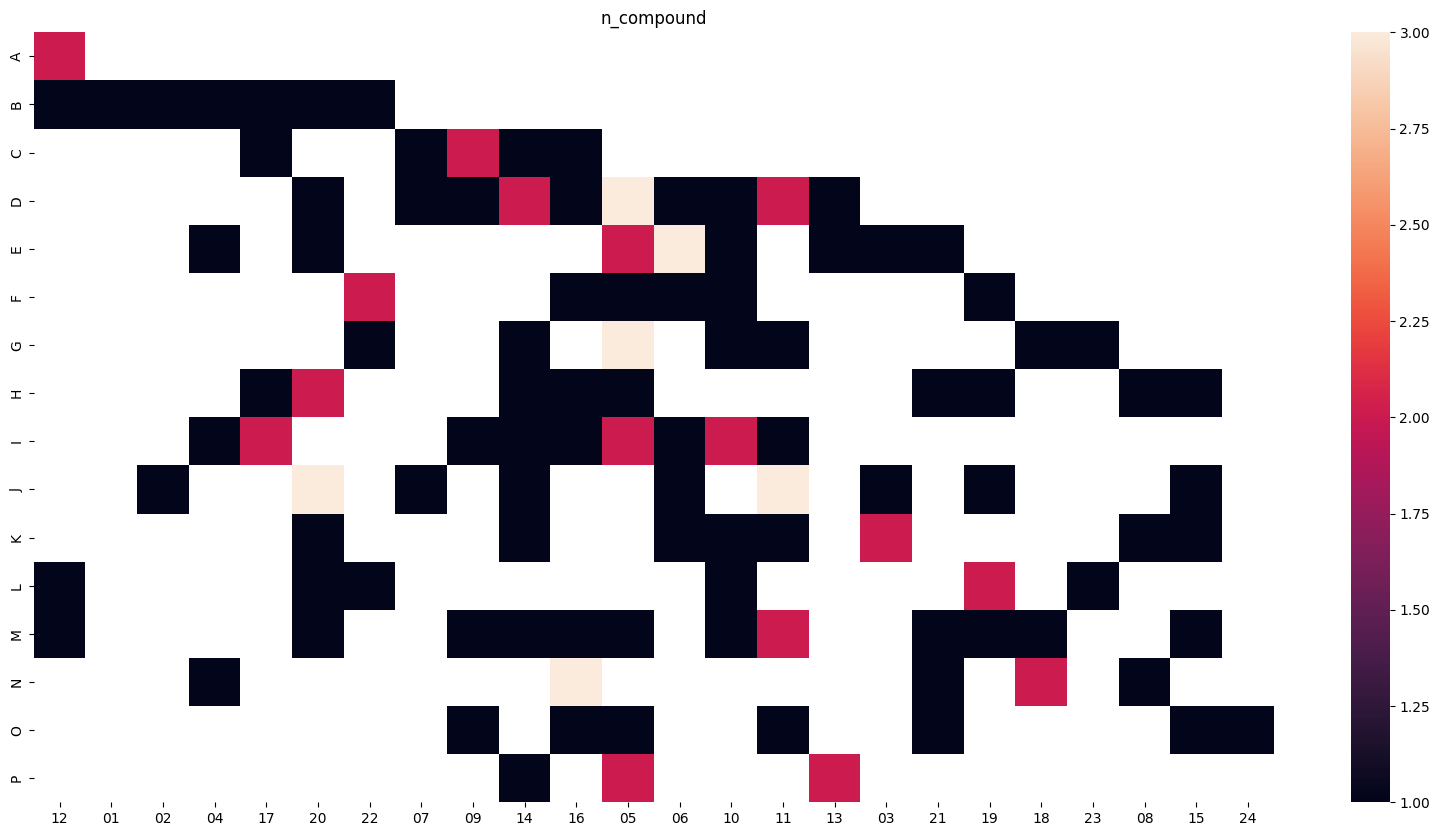

In [654]:
show_distribution(merge_table.filter(pl.col("Metadata_JCP2022").is_in(between1_name)))

In [655]:
merge_table_between1 = (merge_table.filter(
    pl.col("Metadata_JCP2022").is_in(between1_name))
.sort(by=["Metadata_Source", "Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"]))

merge_table_between_keep1 = (merge_table_between1.group_by("Metadata_Source")
     .agg(pl.struct(pl.col("Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"))
          .sort()
          .sample(90, seed=seed))
     .sort(by="Metadata_Source")
    .explode("Metadata_JCP2022")
    .unnest("Metadata_JCP2022"))

In [656]:
merge_table_between1 = (merge_table_between1.join(merge_table_between_keep1,
                         on=["Metadata_Source","Metadata_JCP2022", "Metadata_Plate", 
                             "Metadata_Well", "Metadata_Batch"],
                         how="inner"))

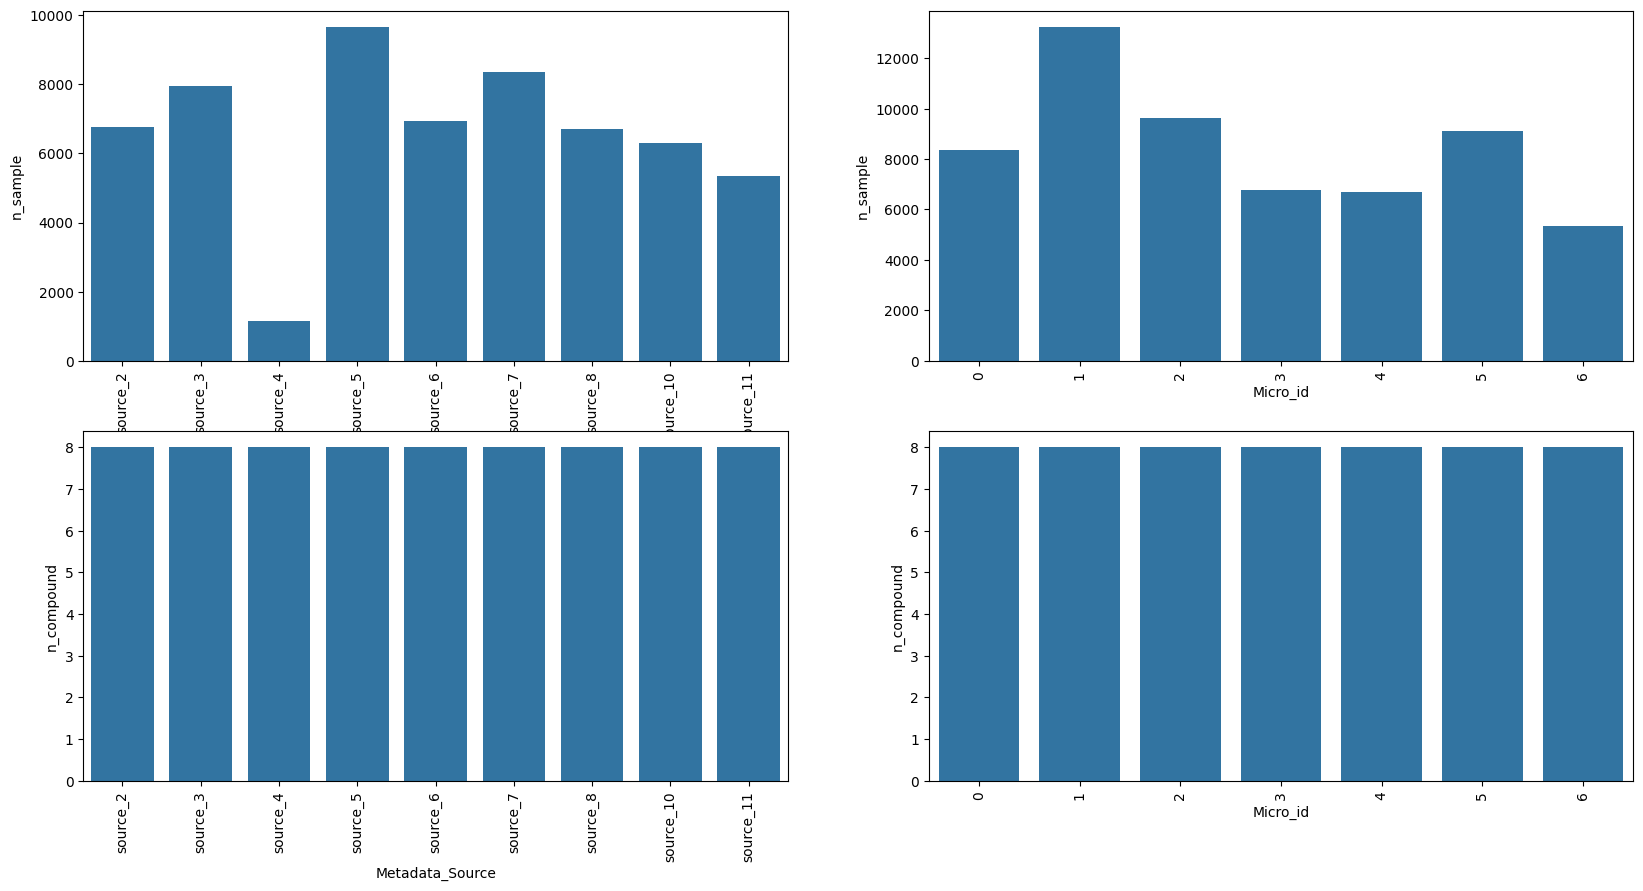

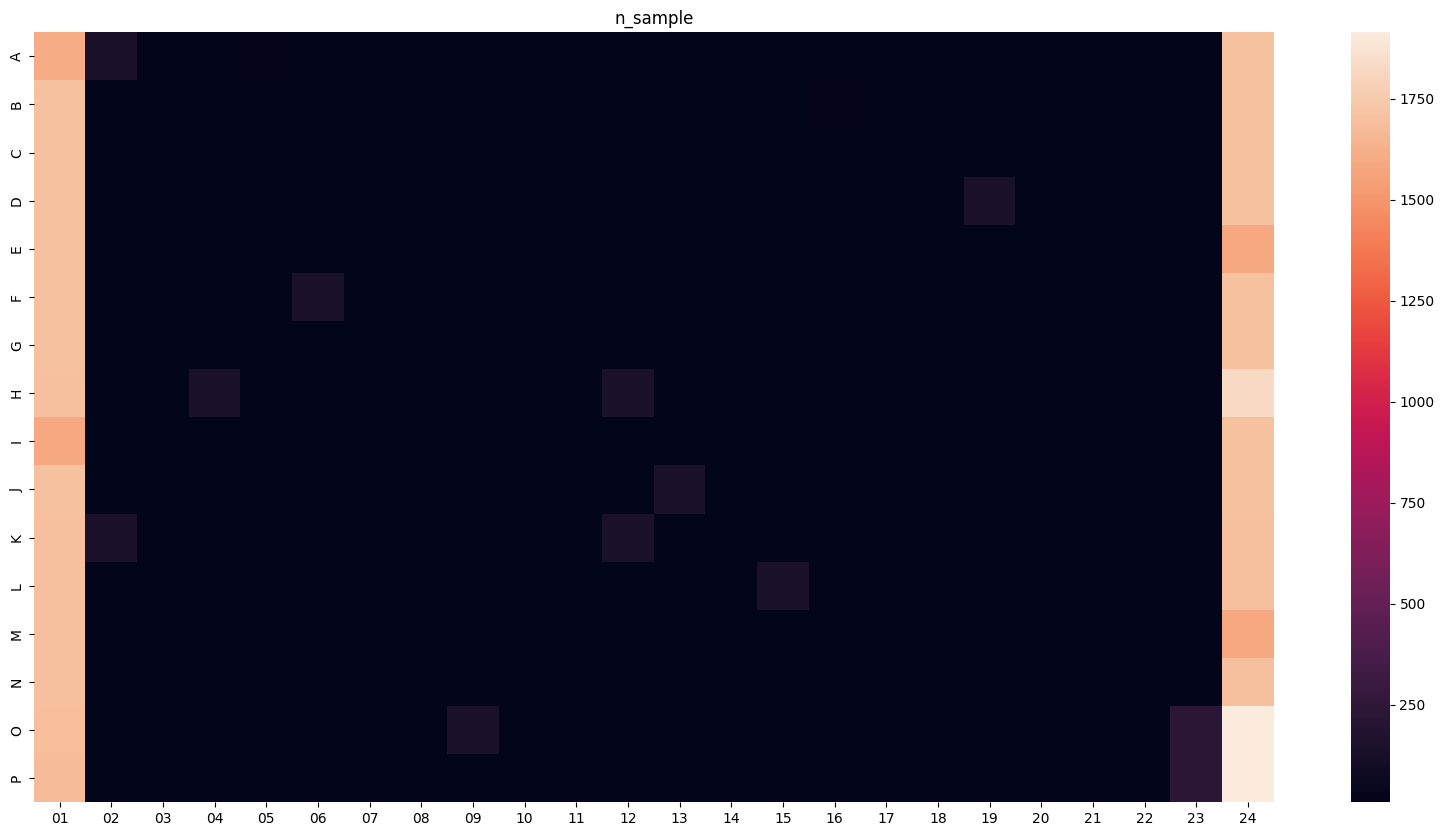

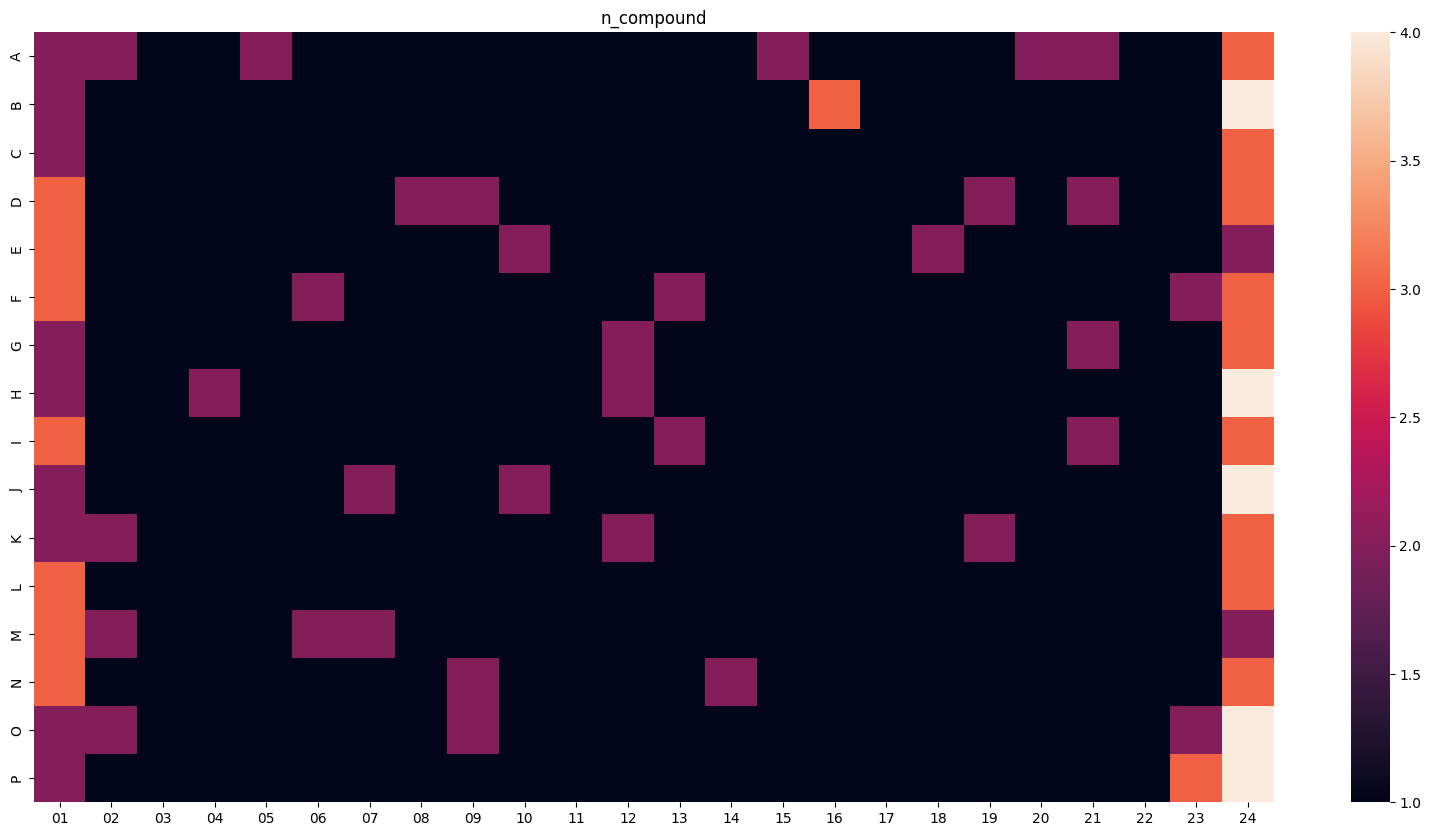

In [657]:
show_distribution(merge_table.filter(pl.col("Metadata_JCP2022").is_in(between2_name)))

In [658]:
merge_table_between2 = (merge_table.filter(
    pl.col("Metadata_JCP2022").is_in(between2_name))
.sort(by=["Metadata_Source", "Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"]))

merge_table_between_keep2 = (merge_table_between2.group_by("Metadata_Source")
     .agg(pl.struct(pl.col("Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"))
          .sort()
          .sample(90, seed=seed))
     .sort(by="Metadata_Source")
    .explode("Metadata_JCP2022")
    .unnest("Metadata_JCP2022"))

In [659]:
merge_table_between2 = (merge_table_between2.join(merge_table_between_keep2,
                         on=["Metadata_Source","Metadata_JCP2022", "Metadata_Plate", 
                             "Metadata_Well", "Metadata_Batch"],
                         how="inner"))

### e) Down Sampling of treatment

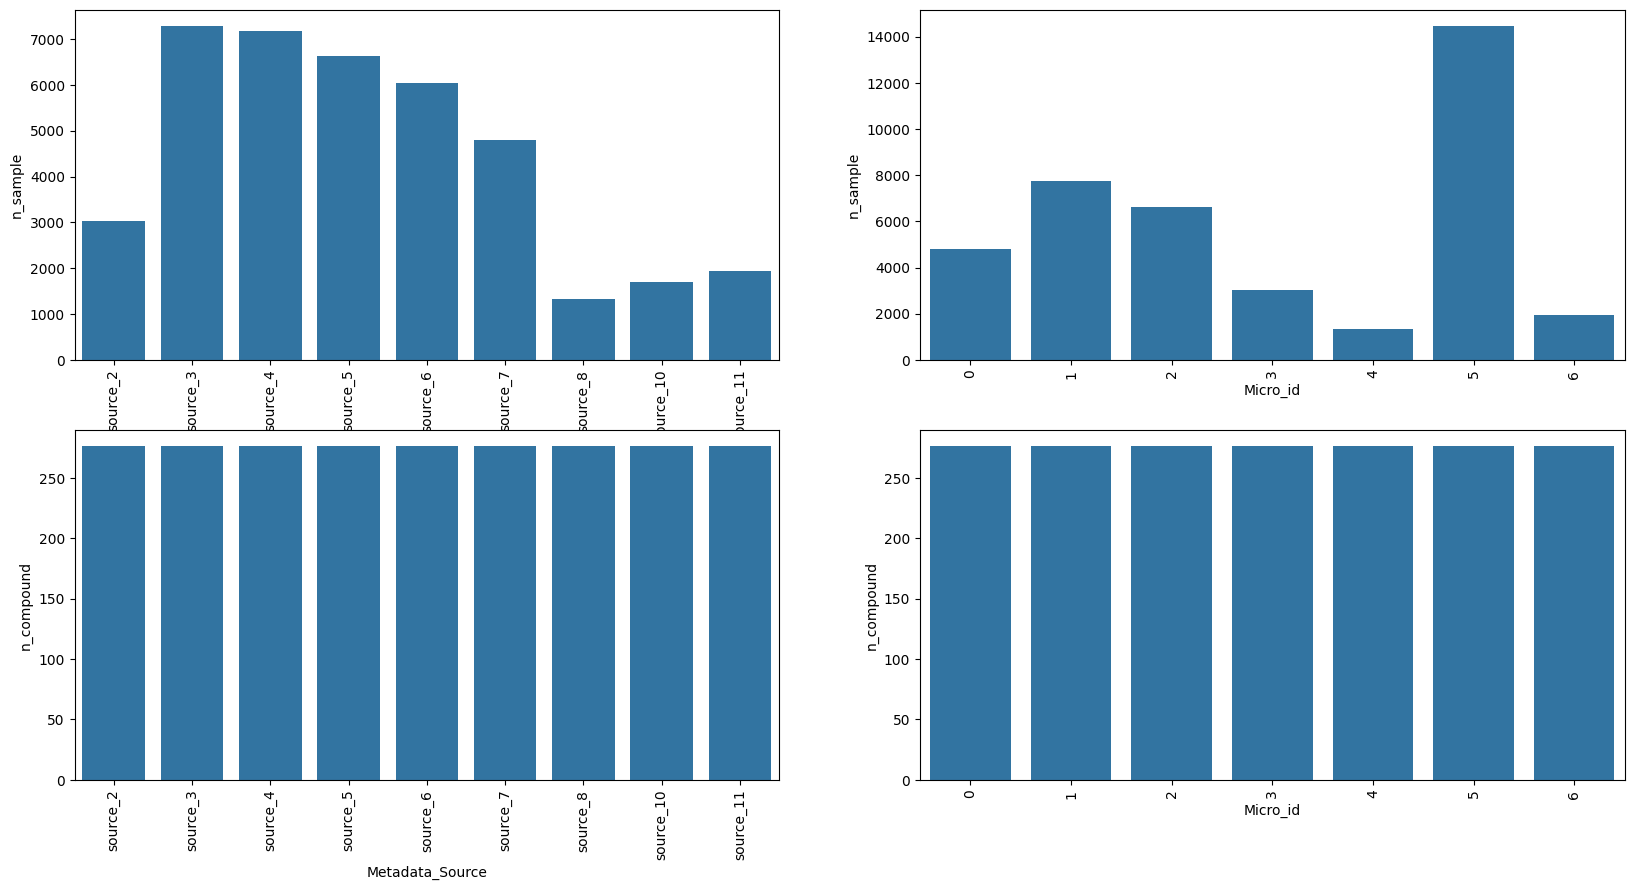

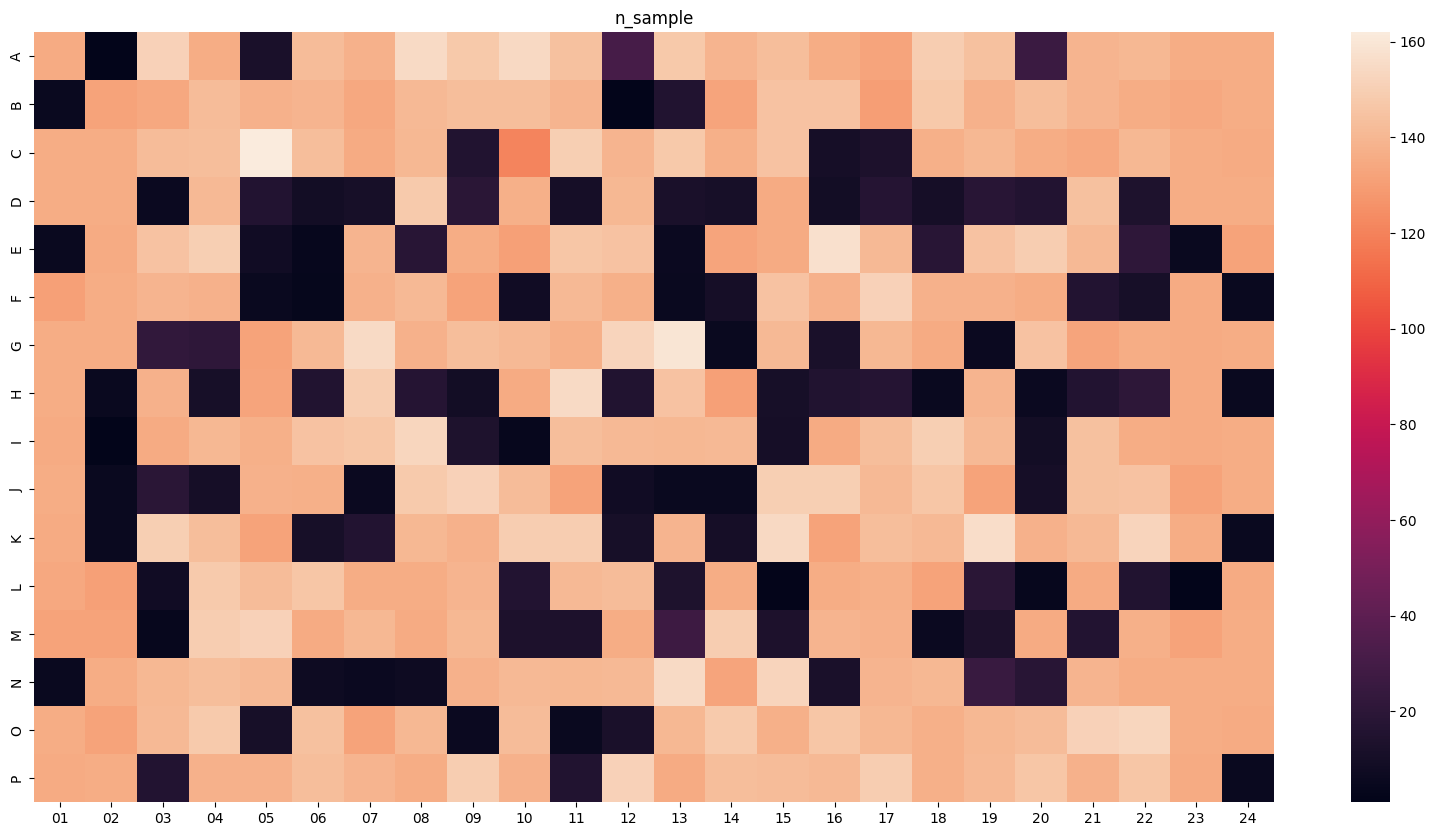

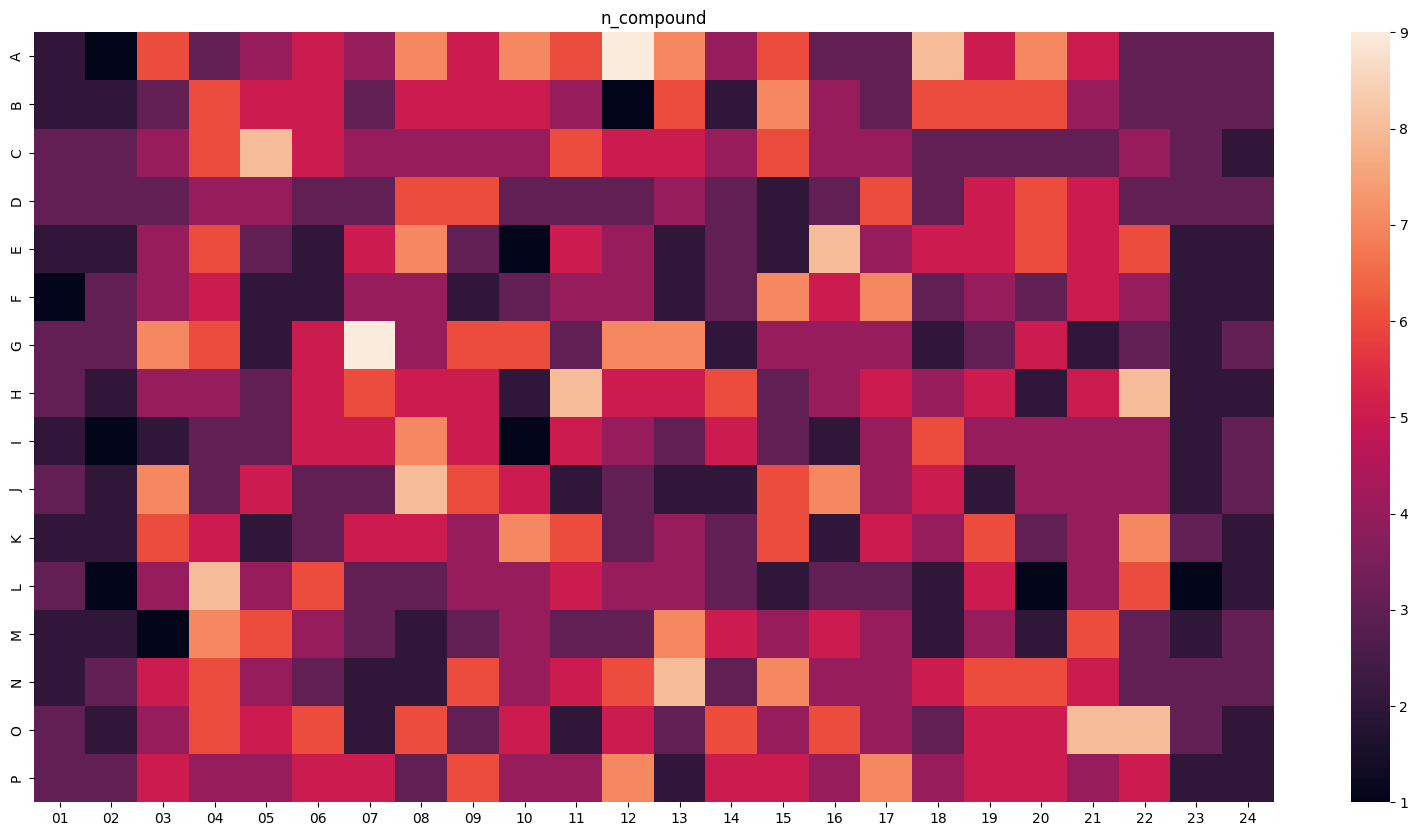

In [660]:
show_distribution(merge_table.filter(pl.col("Metadata_JCP2022").is_in(trt_name)))

In [661]:
merge_table_trt = (merge_table.filter(
    pl.col("Metadata_JCP2022").is_in(trt_name))
.filter(
    pl.col("Metadata_Source").str.contains("_8$") != True)
.sort(by=["Metadata_Source", "Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"]))

merge_table_trt_keep = (merge_table_trt.group_by("Metadata_Source")
     .agg(pl.struct(pl.col("Metadata_JCP2022", "Metadata_Plate", "Metadata_Well", "Metadata_Batch"))
          .sort()
          .sample(1350, seed=seed))
     .sort(by="Metadata_Source")
    .explode("Metadata_JCP2022")
    .unnest("Metadata_JCP2022"))

In [662]:
merge_table_trt = (merge_table_trt.join(merge_table_trt_keep,
                         on=["Metadata_Source","Metadata_JCP2022", "Metadata_Plate", 
                             "Metadata_Well", "Metadata_Batch"],
                         how="inner")
                       .join((merge_table.filter(
                           pl.col("Metadata_JCP2022").is_in(trt_name))
                              .filter(
                                  pl.col("Metadata_Source").str.contains("_8$"))),
                             on=merge_table.columns,
                             how="outer")).unique()

### f) merging all group sampled

In [663]:
merge_table_filtered = (merge_table_trt.join(
                        merge_table_between1,
                        on=merge_table_trt.columns,
                        how="outer")
                     .join(merge_table_between2,
                           on=merge_table_trt.columns,
                           how="outer")
                     .join(merge_table_control,
                           on=merge_table_trt.columns,
                           how="outer"))
    

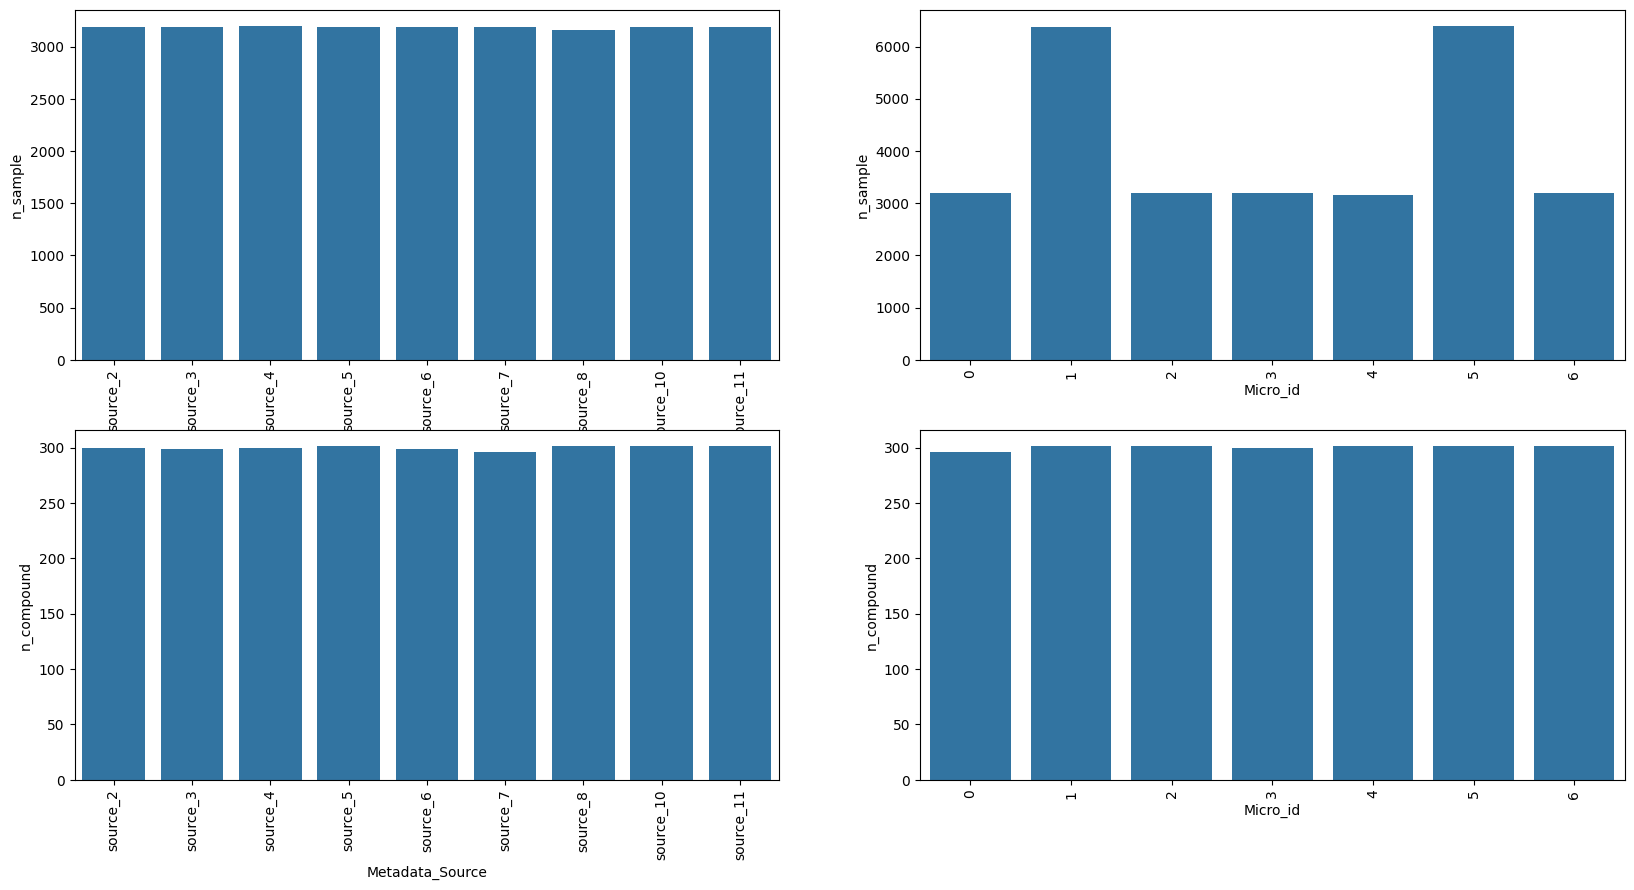

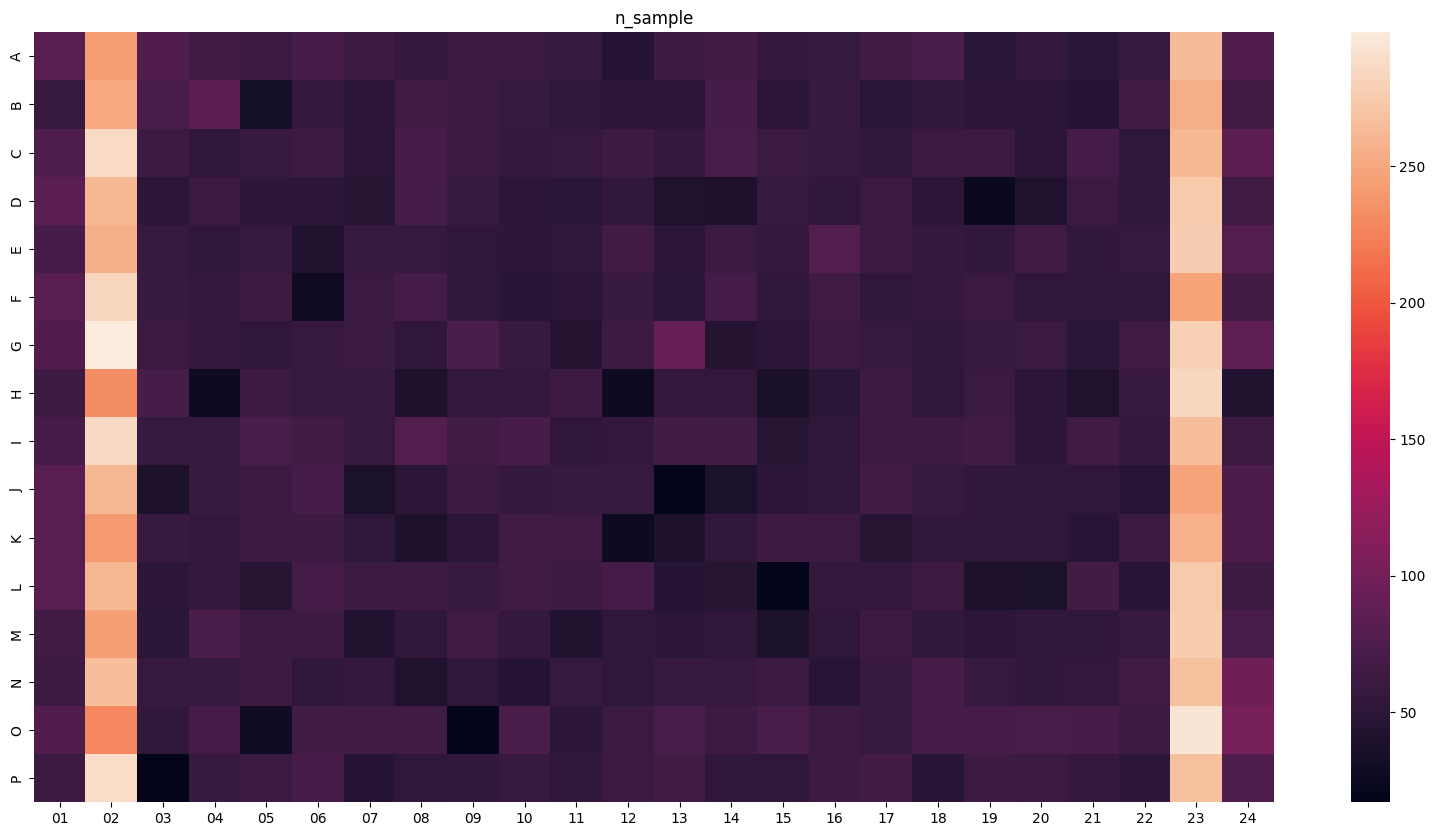

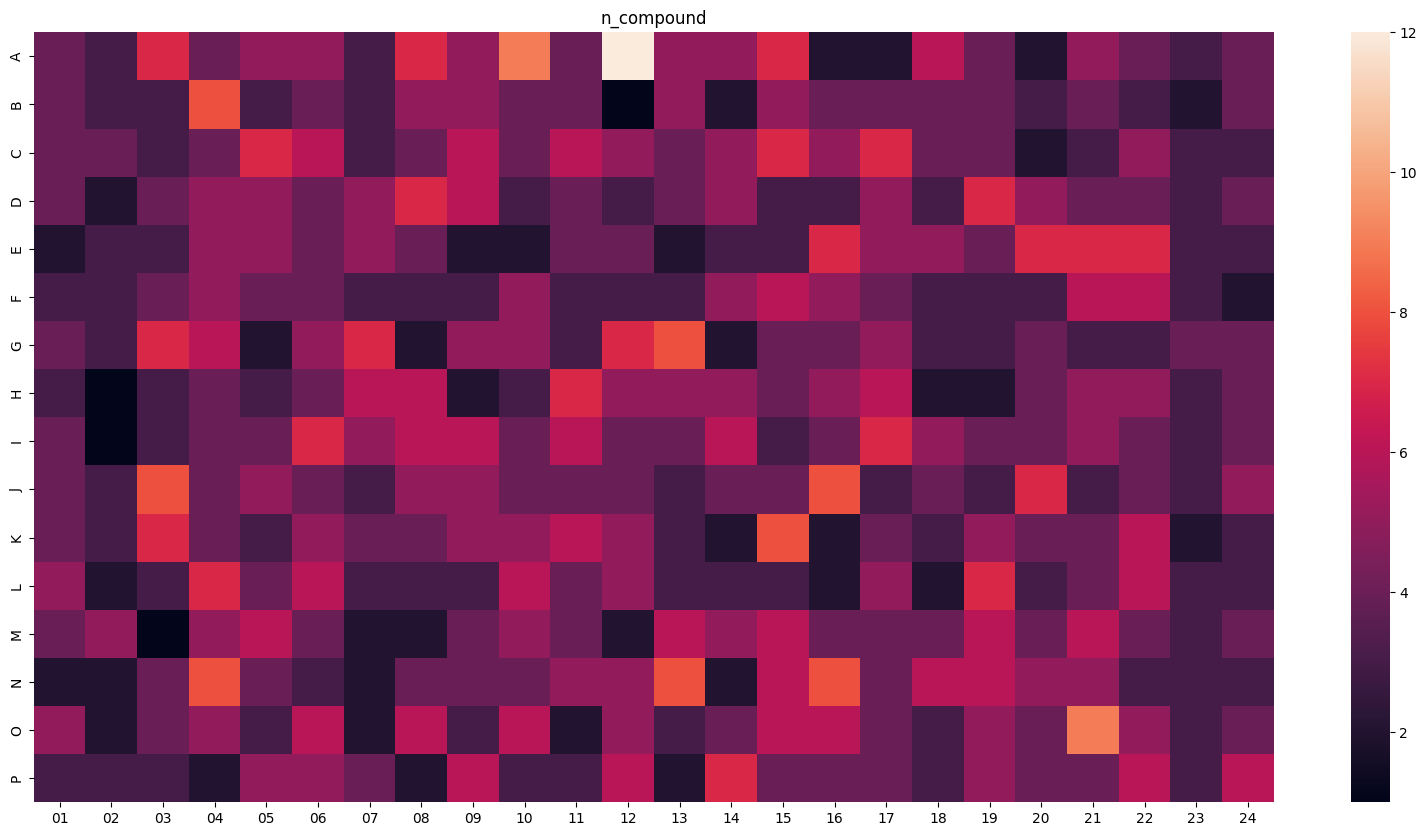

In [664]:
show_distribution(merge_table_filtered)

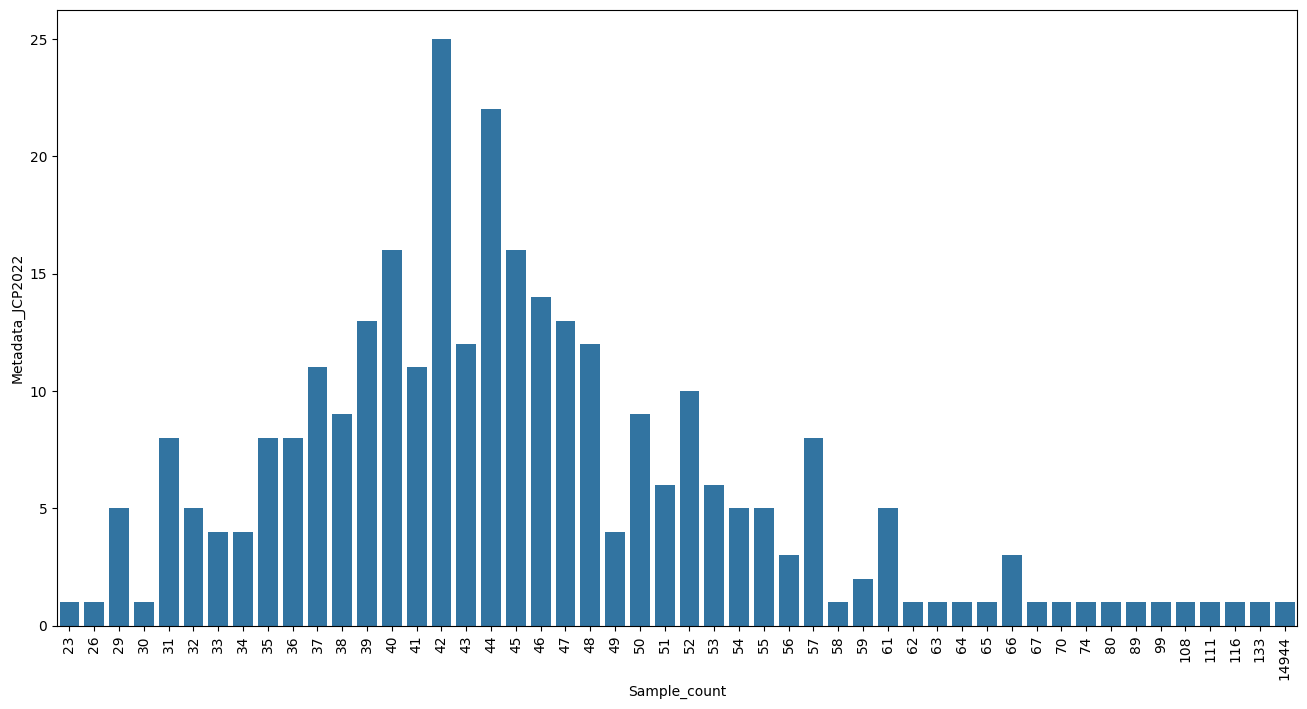

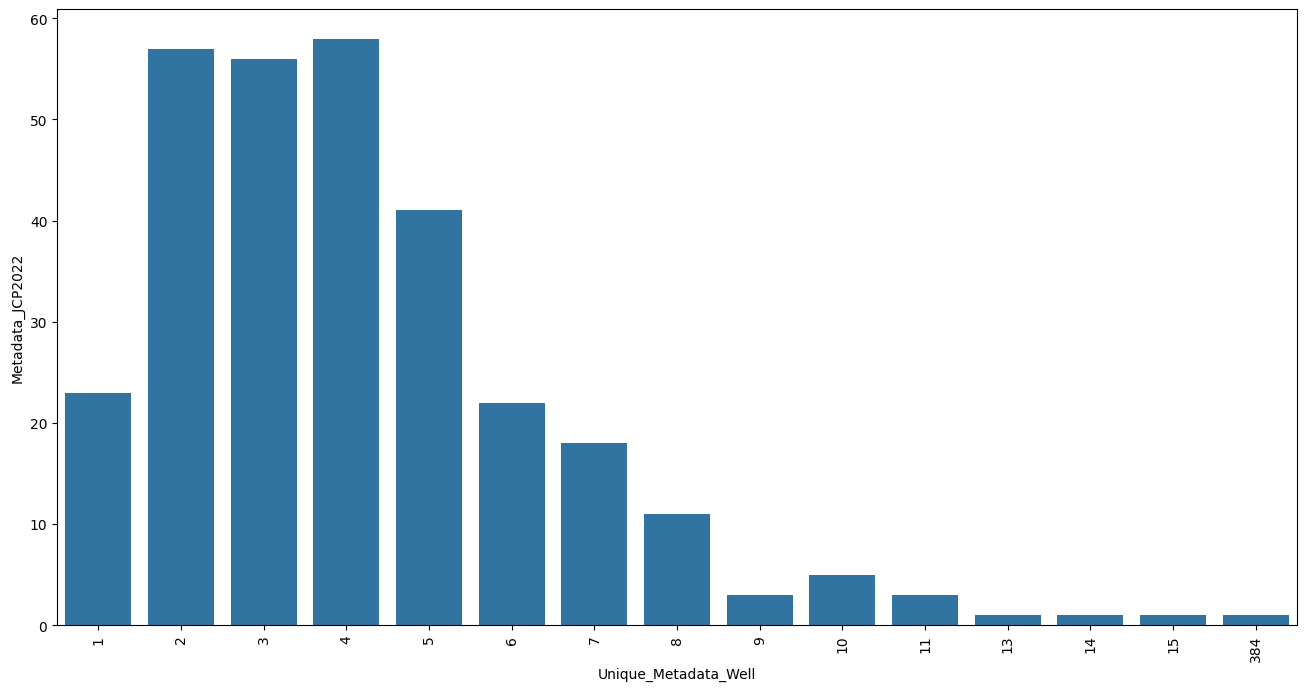

In [665]:
compounds_info_filtered = (merge_table_filtered.group_by("Metadata_JCP2022")
                  .agg(pl.col("Metadata_InChIKey").count().alias("Sample_count"),
                       pl.col("Metadata_Source", "Metadata_Well", "Micro_id")
                       .n_unique().name.prefix("Unique_"))
                       )

fig, ax1 = plt.subplots(1, figsize=(16,8))

df_filtered = (compounds_info_filtered.group_by("Sample_count")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Sample_count"))

sns.barplot(df_filtered,
            x="Sample_count",
            y="Metadata_JCP2022",
            ax=ax1)
ax1.tick_params(axis='x', rotation=90)

fig, ax2 = plt.subplots(1, figsize=(16,8))

df2_filtered = (compounds_info_filtered.group_by("Unique_Metadata_Well")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Unique_Metadata_Well"))

sns.barplot(df2_filtered,
            x="Unique_Metadata_Well",
            y="Metadata_JCP2022",
            ax=ax2)
ax2.tick_params(axis='x', rotation=90)

### g) Let's see if some compounds has disapeared from sources and how to put them back in a meaningful way

#### Count of Sample per source per compound
#### Count of Unique Well per source per compound
Let's compute these metric without considering the control compounds.

Text(0.5, 1.0, 'Count of Unique Well per source per compound')

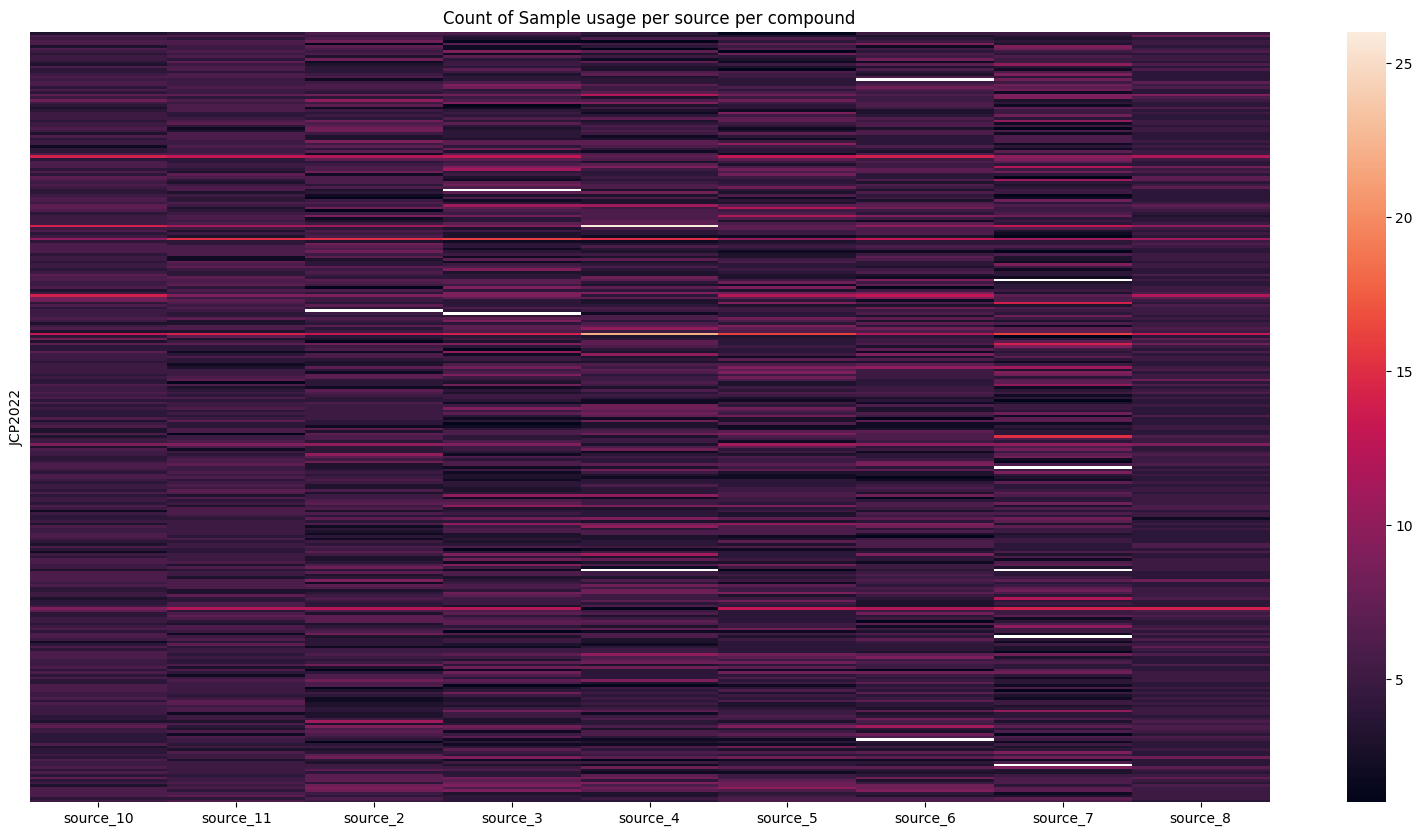

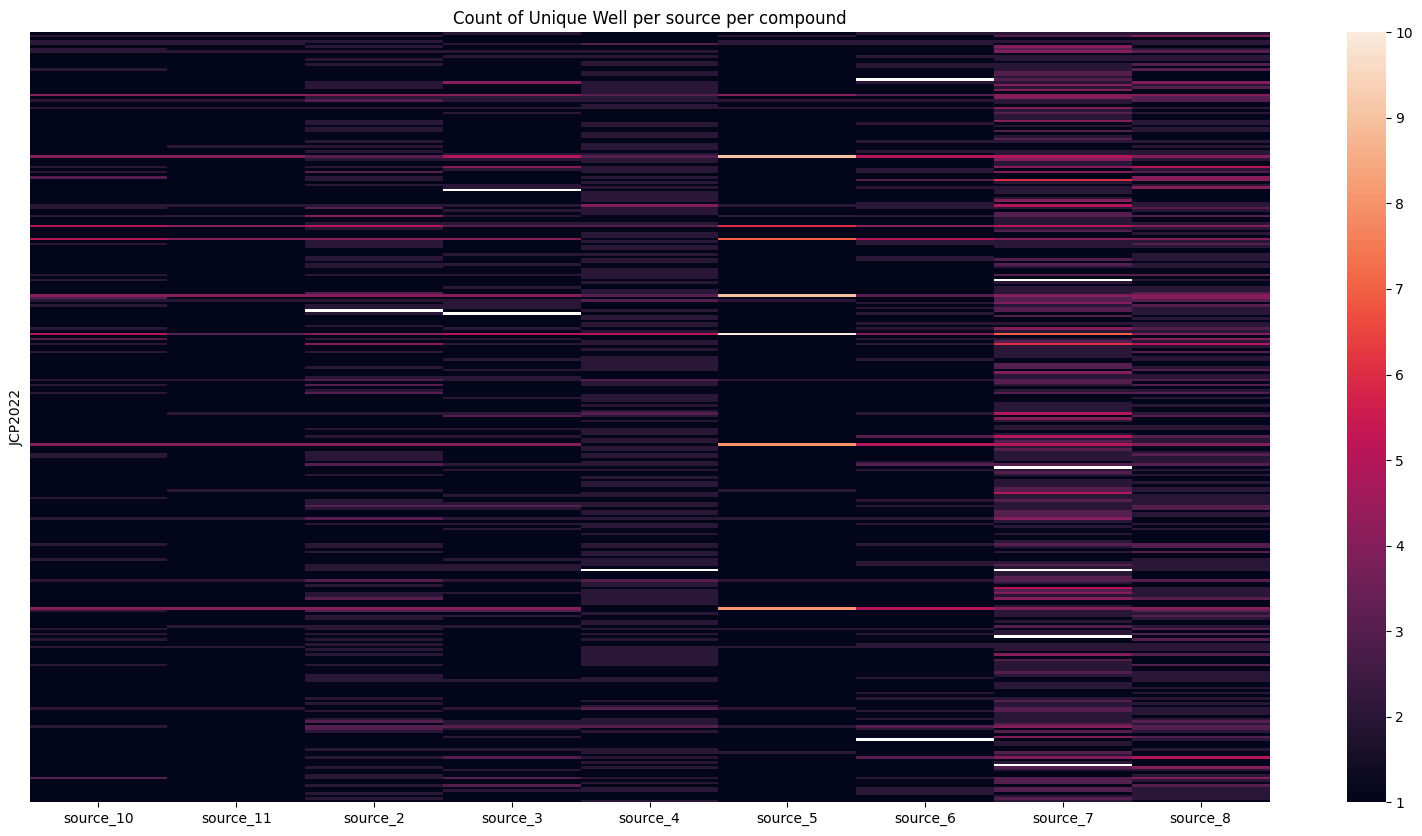

In [666]:
well_p_source_p_compound = (merge_table_filtered.filter(pl.col("Metadata_JCP2022").is_in(controle_name) != True)
                            .group_by(["Metadata_JCP2022", "Metadata_Source"])
 .agg(pl.col("Metadata_JCP2022").count().alias("n_sample"),
      pl.col("Metadata_Well").n_unique().alias("n_well_unique"))
 .sort(by=["Metadata_JCP2022", "Metadata_Source"]))

count_sample_p_source_p_compound = well_p_source_p_compound.pivot(index="Metadata_JCP2022",
                                                                 columns="Metadata_Source",
                                                                 values="n_sample")

unique_well_p_source_p_compound = well_p_source_p_compound.pivot(index="Metadata_JCP2022",
                                                                 columns="Metadata_Source",
                                                                 values="n_well_unique")

fig1, ax1 = plt.subplots(1, figsize=(20,10))
sns.heatmap(count_sample_p_source_p_compound.select(pl.all().exclude("Metadata_JCP2022")),
            ax=ax1)

ax1.set_xticklabels(count_sample_p_source_p_compound.columns[1:])
ax1.tick_params(left = False, labelleft = False)
ax1.set_ylabel("JCP2022")
ax1.set_title("Count of Sample usage per source per compound")

fig2, ax2 = plt.subplots(1, figsize=(20,10))
sns.heatmap(unique_well_p_source_p_compound.select(pl.all().exclude("Metadata_JCP2022")),
            ax=ax2)
           #robust=True)
ax2.set_xticklabels(unique_well_p_source_p_compound.columns[1:])
ax2.tick_params(left = False, labelleft = False)
ax2.set_ylabel("JCP2022")
ax2.set_title("Count of Unique Well per source per compound")

### h) Last Concerns: adding back removed sample from some sources
* Some compounds are not anymore in some sources, let's add them artificially by comparing with the data unfiltered. 

Text(0.5, 1.0, 'Count of Unique Well per source per compound')

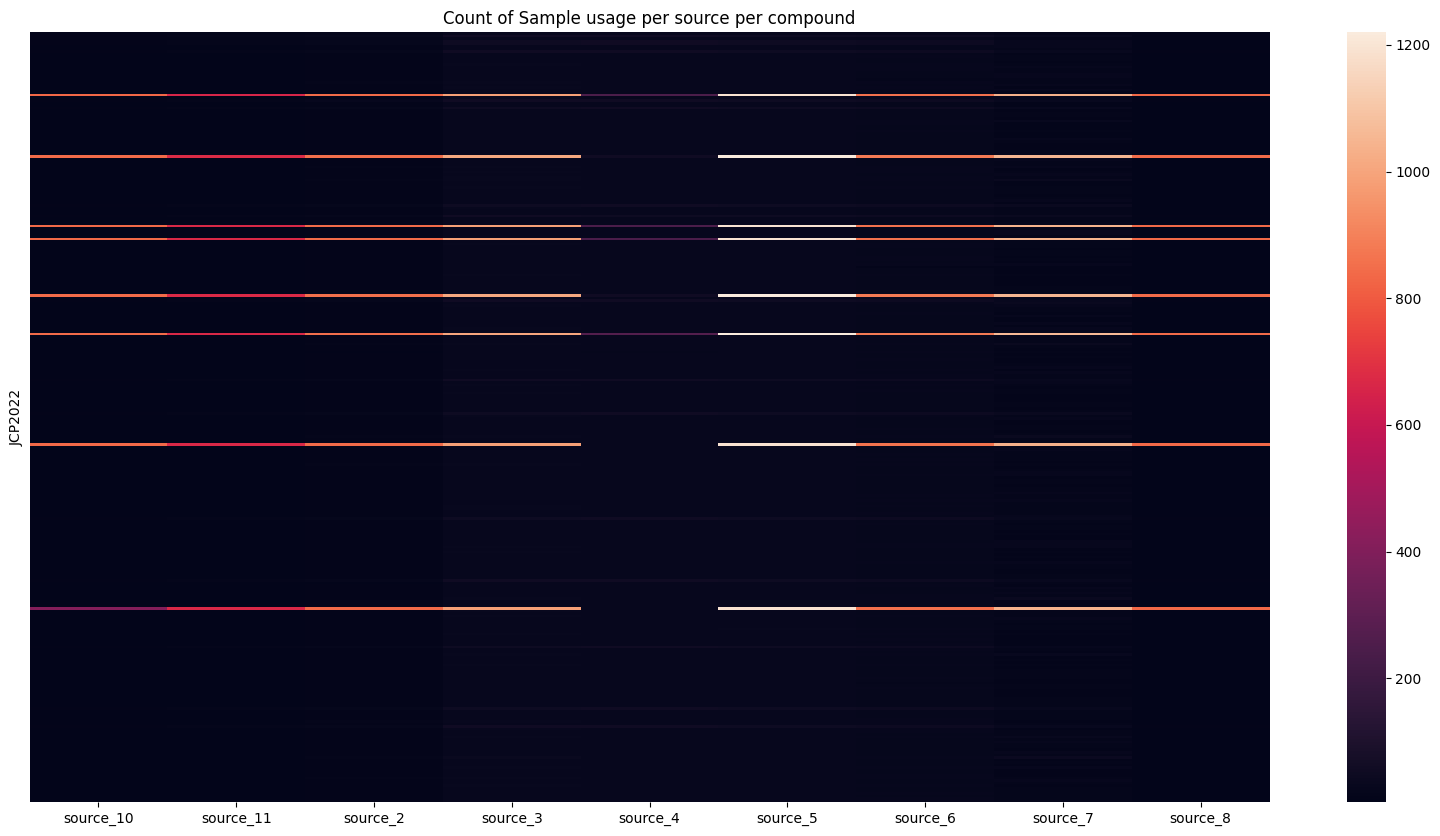

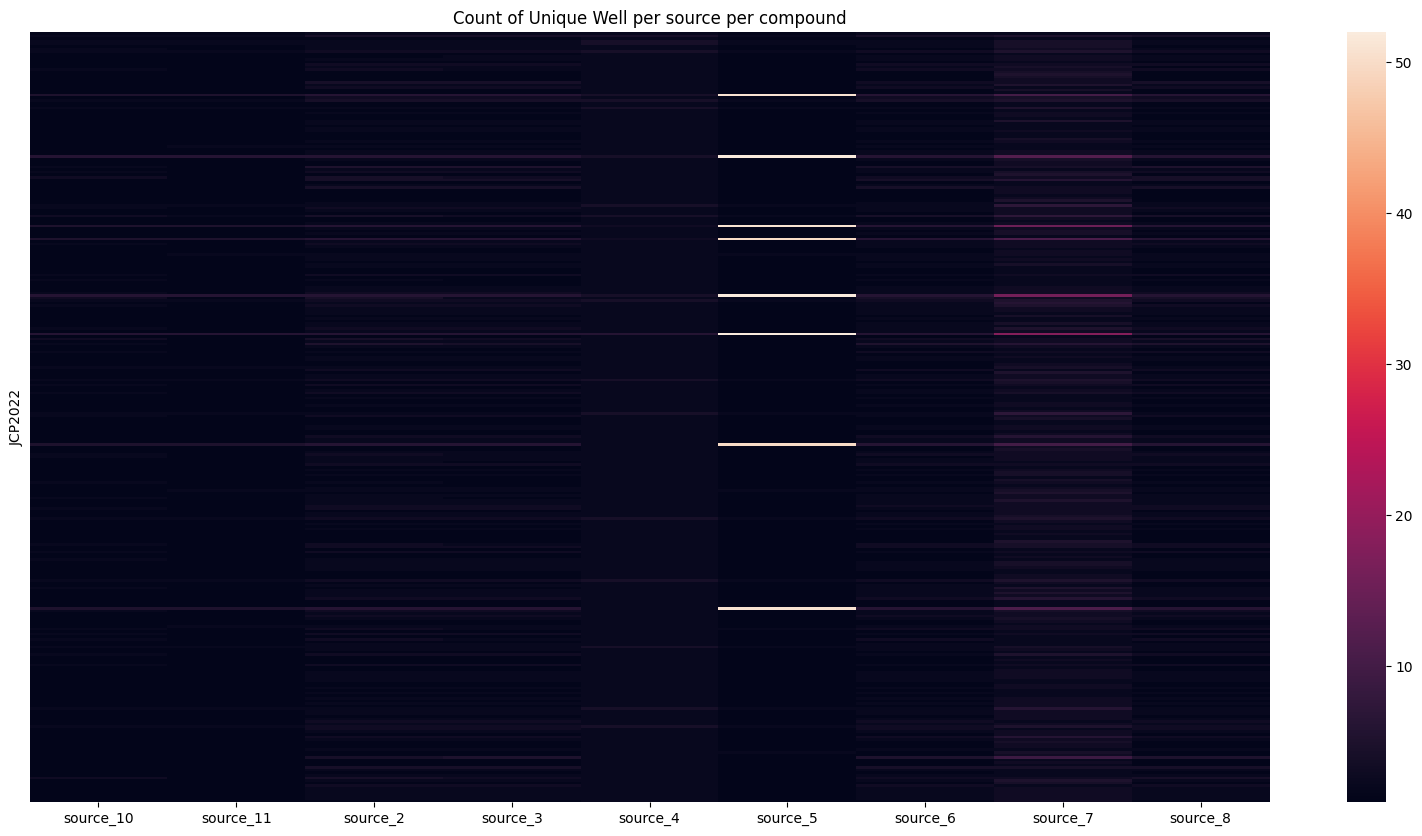

In [667]:
well_p_source_p_compound_raw = (merge_table.filter(pl.col("Metadata_JCP2022").is_in(controle_name) != True)
                            .group_by(["Metadata_JCP2022", "Metadata_Source"])
 .agg(pl.col("Metadata_JCP2022").count().alias("n_sample"),
      pl.col("Metadata_Well").n_unique().alias("n_well_unique"))
 .sort(by=["Metadata_JCP2022", "Metadata_Source"]))

count_sample_p_source_p_compound_raw = well_p_source_p_compound_raw.pivot(index="Metadata_JCP2022",
                                                                 columns="Metadata_Source",
                                                                 values="n_sample")

unique_well_p_source_p_compound_raw = well_p_source_p_compound_raw.pivot(index="Metadata_JCP2022",
                                                                 columns="Metadata_Source",
                                                                 values="n_well_unique")

fig1, ax1 = plt.subplots(1, figsize=(20,10))
sns.heatmap(count_sample_p_source_p_compound_raw.select(pl.all().exclude("Metadata_JCP2022")),
            ax=ax1)

ax1.set_xticklabels(count_sample_p_source_p_compound_raw.columns[1:])
ax1.tick_params(left = False, labelleft = False)
ax1.set_ylabel("JCP2022")
ax1.set_title("Count of Sample usage per source per compound")

fig2, ax2 = plt.subplots(1, figsize=(20,10))
sns.heatmap(unique_well_p_source_p_compound_raw.select(pl.all().exclude("Metadata_JCP2022")),
            ax=ax2)
           #robust=True)
ax2.set_xticklabels(unique_well_p_source_p_compound_raw.columns[1:])
ax2.tick_params(left = False, labelleft = False)
ax2.set_ylabel("JCP2022")
ax2.set_title("Count of Unique Well per source per compound")

In [668]:
#This table compare the amount of sample and unique well use per source and per compounds
well_p_source_p_compound_comp = (well_p_source_p_compound_raw.join(
    well_p_source_p_compound,
    on=["Metadata_JCP2022","Metadata_Source"],
    how="outer",
    suffix="_filter"))
well_p_source_p_compound_comp.head()

Metadata_JCP2022,Metadata_Source,n_sample,n_well_unique,n_sample_filter,n_well_unique_filter
str,str,u32,u32,u32,u32
"""JCP2022_000794…","""source_10""",6,1,3,1
"""JCP2022_000794…","""source_11""",7,1,4,1
"""JCP2022_000794…","""source_2""",11,2,6,1
"""JCP2022_000794…","""source_3""",27,2,6,2
"""JCP2022_000794…","""source_4""",26,2,4,1


Let's compute in average the amount of sample and amount of unique well there is per compounds and per sources
In this way instead of just putting back on sample for each compounds missing in some sources, we add back a coherent amount of samples and wells relative to the average of what exists for this compound in for the sources.  

In [669]:

Sample_mean_p_source_p_compound_comp = (well_p_source_p_compound_comp.select(
    pl.col("Metadata_JCP2022"),
    pl.col("Metadata_Source"),
    pl.col("n_sample_filter").mean().over("Metadata_Source").alias("Source_mean"),
    pl.col("n_sample_filter").mean().over("Metadata_JCP2022").alias("Compound_mean"))
 .with_columns(((pl.col("Source_mean") + pl.col("Compound_mean"))/2).alias("Sample_mean"))
 .select("Metadata_JCP2022", "Metadata_Source", "Sample_mean"))

Well_mean_p_source_p_compound_comp = (well_p_source_p_compound_comp.select(
    pl.col("Metadata_JCP2022"),
    pl.col("Metadata_Source"),
    pl.col("n_well_unique_filter").mean().over("Metadata_Source").alias("Source_mean"),
    pl.col("n_well_unique_filter").mean().over("Metadata_JCP2022").alias("Compound_mean"))
 .with_columns(((pl.col("Source_mean") + pl.col("Compound_mean"))/2).alias("Well_mean"))
 .select("Metadata_JCP2022", "Metadata_Source", "Well_mean"))

mean_p_source_p_compound = (Sample_mean_p_source_p_compound_comp
                                        .join(Well_mean_p_source_p_compound_comp,
                                          on=["Metadata_JCP2022", "Metadata_Source"],
                                          how="outer"))

mean_p_source_p_compound = mean_p_source_p_compound.with_columns(
    pl.col("Sample_mean").round(0),
    pl.col("Well_mean").round(0))

In [670]:
well_p_source_p_compound_comp = well_p_source_p_compound_comp.with_columns(
    pl.col("n_sample_filter", "n_well_unique_filter").fill_null(pl.lit(0)))

In [671]:
compounds_to_retrieve = (well_p_source_p_compound_comp.filter(
    (pl.col("n_well_unique_filter") == 0))
 .join(mean_p_source_p_compound,
       on=["Metadata_JCP2022", "Metadata_Source"],
       how="inner"))

In [672]:
compounds_to_retrieve

Metadata_JCP2022,Metadata_Source,n_sample,n_well_unique,n_sample_filter,n_well_unique_filter,Sample_mean,Well_mean
str,str,u32,u32,u32,u32,f64,f64
"""JCP2022_010382…","""source_6""",17,1,0,0,5.0,1.0
"""JCP2022_030713…","""source_3""",25,1,0,0,5.0,1.0
"""JCP2022_043332…","""source_7""",11,2,0,0,6.0,2.0
"""JCP2022_047545…","""source_2""",11,2,0,0,5.0,2.0
"""JCP2022_047559…","""source_3""",27,2,0,0,5.0,1.0
"""JCP2022_067887…","""source_7""",11,2,0,0,5.0,2.0
"""JCP2022_079617…","""source_4""",26,2,0,0,4.0,2.0
"""JCP2022_079617…","""source_7""",11,2,0,0,4.0,2.0
"""JCP2022_090051…","""source_7""",13,2,0,0,5.0,2.0


Sampling 5 per each compounds is reasonnable and simplify the query. 

In [673]:
compounds_to_retrieve_table = merge_table.join((compounds_to_retrieve
.select(pl.col("Metadata_JCP2022", "Metadata_Source"))),
                 on=["Metadata_JCP2022", "Metadata_Source"],
                 how="inner")

In [674]:
compounds_to_retrieve_table_keep = (compounds_to_retrieve_table
                   .sort(by=["Metadata_JCP2022", "Metadata_Source", 
                             "Metadata_Plate", "Metadata_Well", "Metadata_Batch"]))

compounds_to_retrieve_table_keep = (compounds_to_retrieve_table_keep
                                    .group_by("Metadata_JCP2022", "Metadata_Source")
     .agg(pl.struct(pl.col("Metadata_Plate", "Metadata_Well", "Metadata_Batch"))
          .sort()
          .sample(5, seed=seed))
     .sort(by=["Metadata_JCP2022", "Metadata_Source"])
    .explode("Metadata_Plate")
    .unnest("Metadata_Plate"))


compounds_to_retrieve_table = (compounds_to_retrieve_table.join(compounds_to_retrieve_table_keep,
                         on=["Metadata_Source","Metadata_JCP2022", "Metadata_Plate", 
                             "Metadata_Well", "Metadata_Batch"],
                         how="inner"))

In [675]:
merge_table_filtered2 = merge_table_filtered.join(compounds_to_retrieve_table,
                          on=merge_table_filtered.columns,
                          how="outer")

#### i) Final distributions

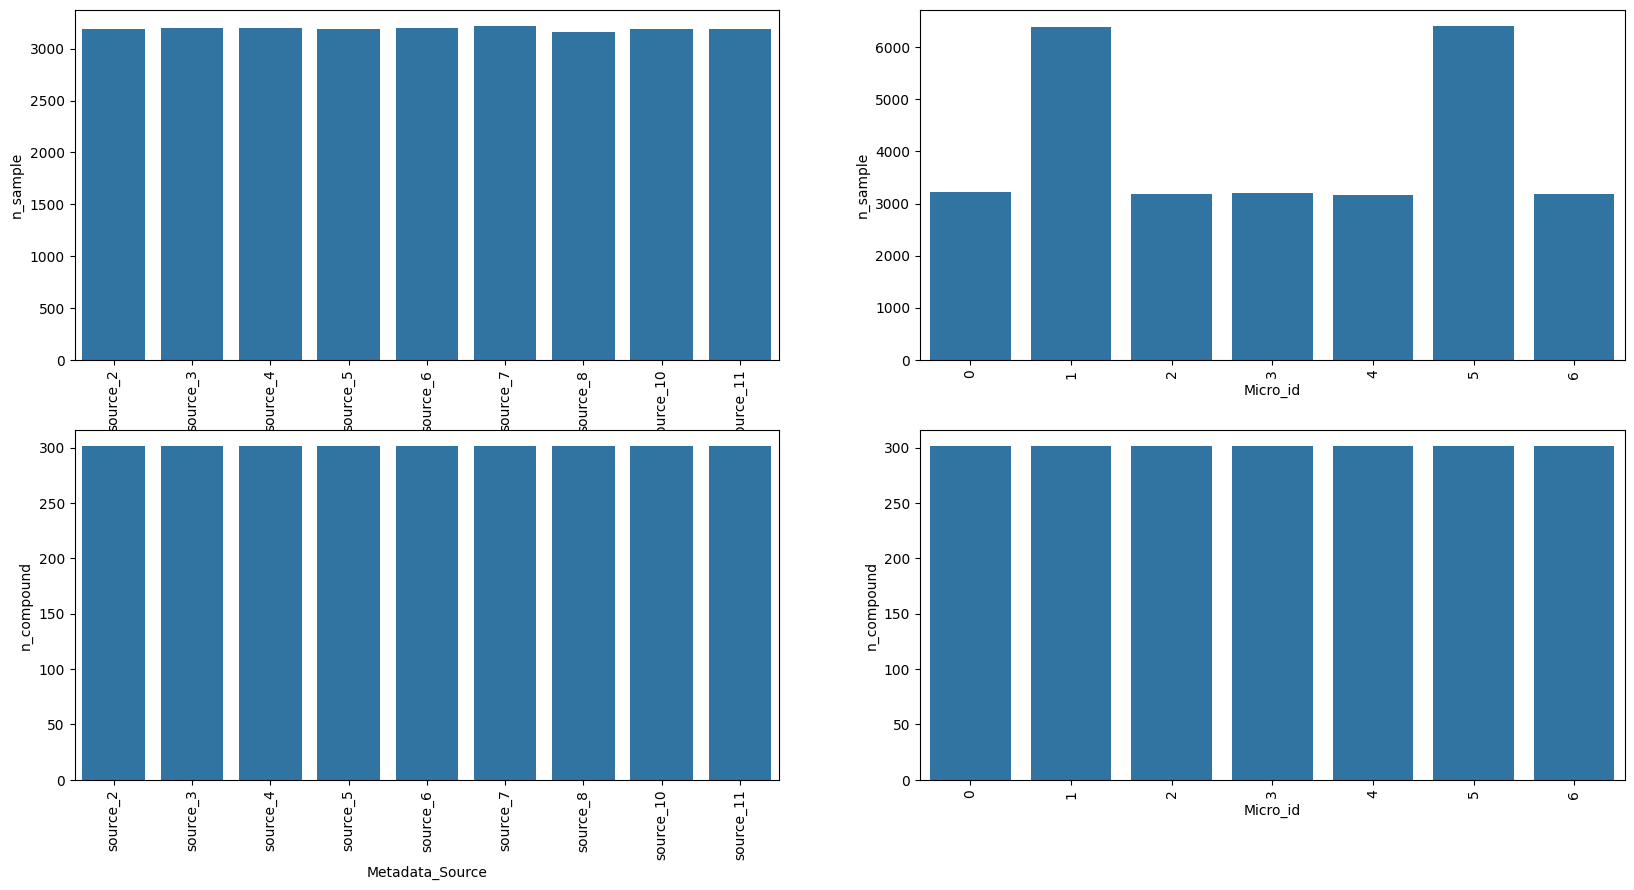

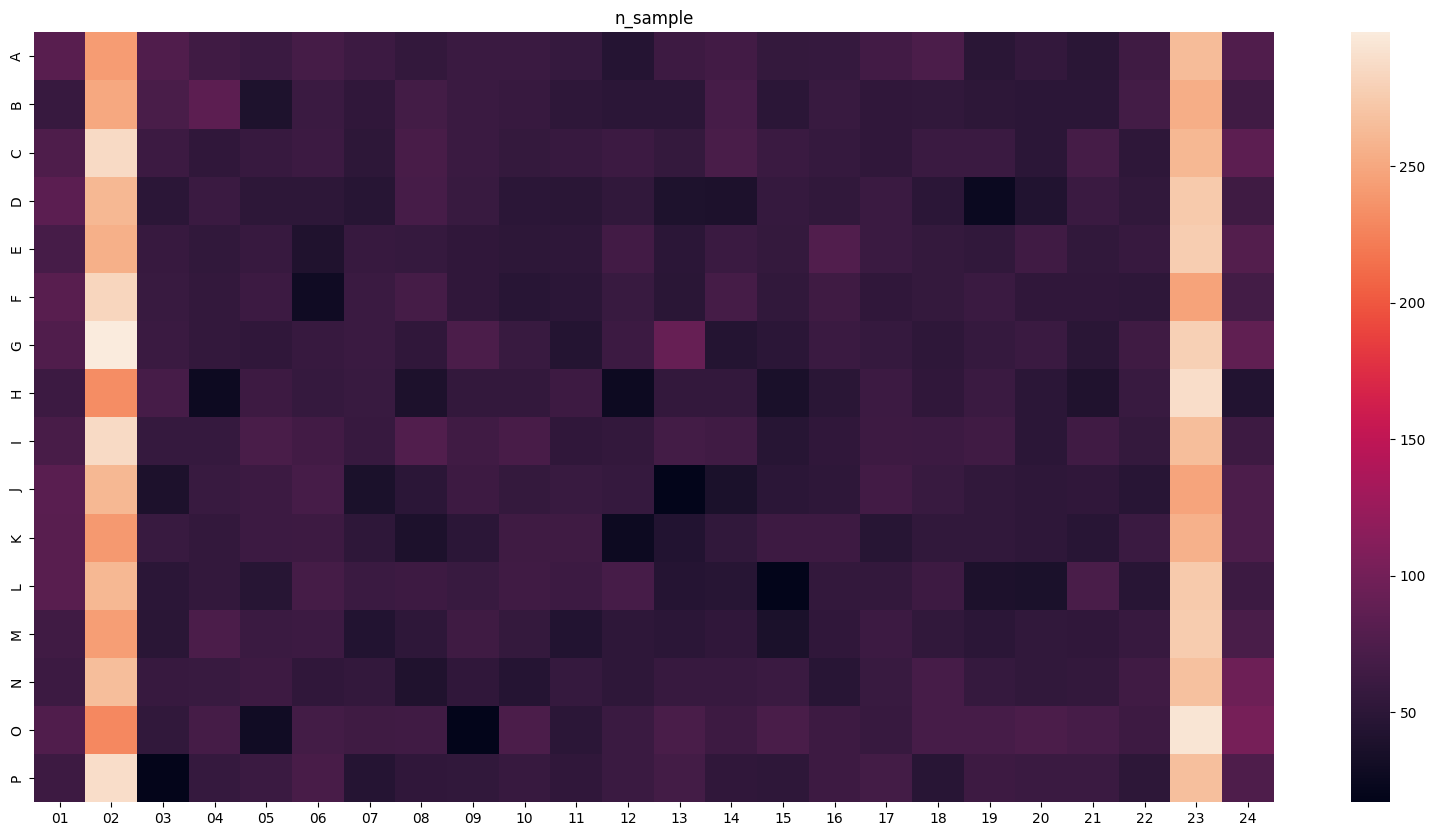

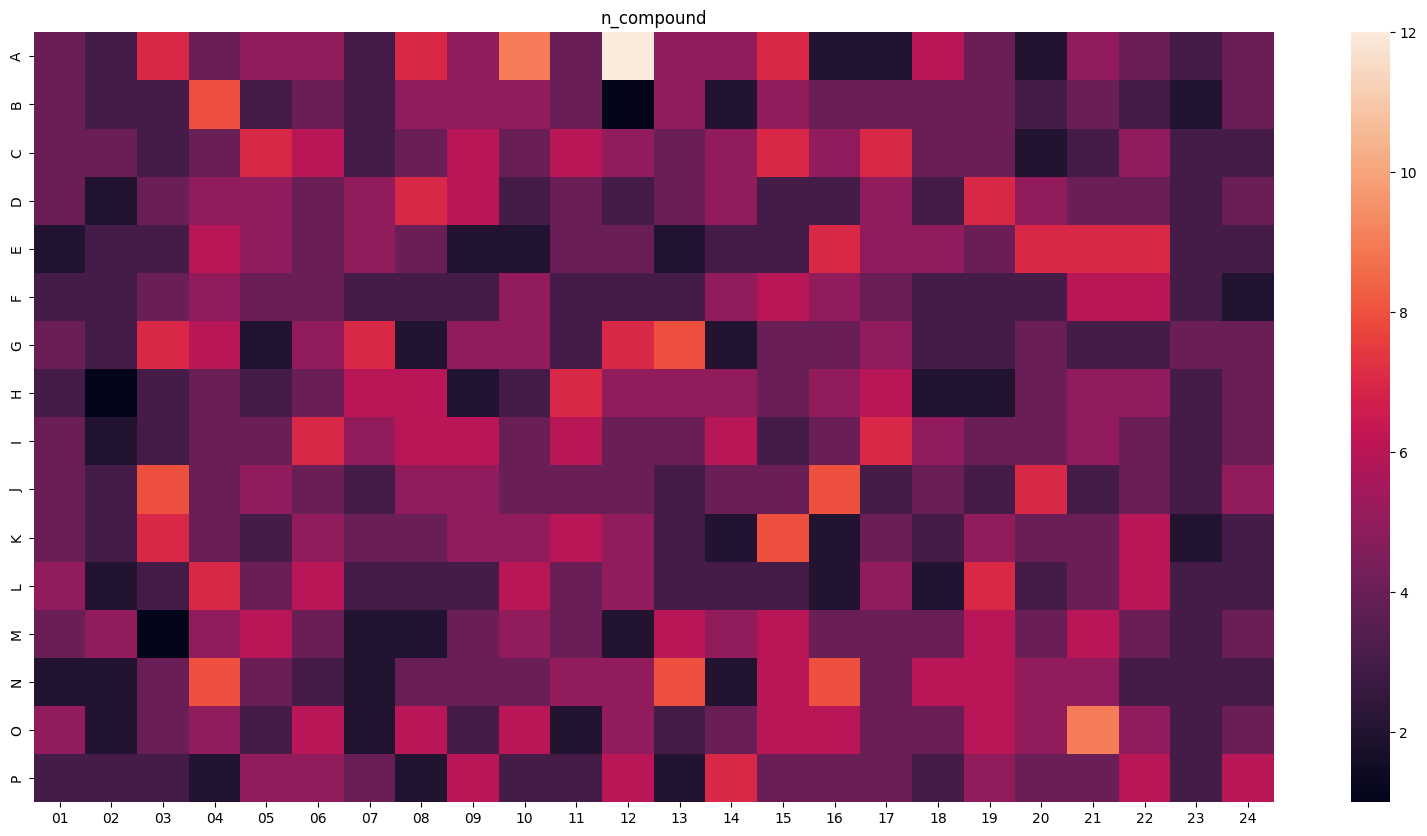

In [676]:
show_distribution(merge_table_filtered2)

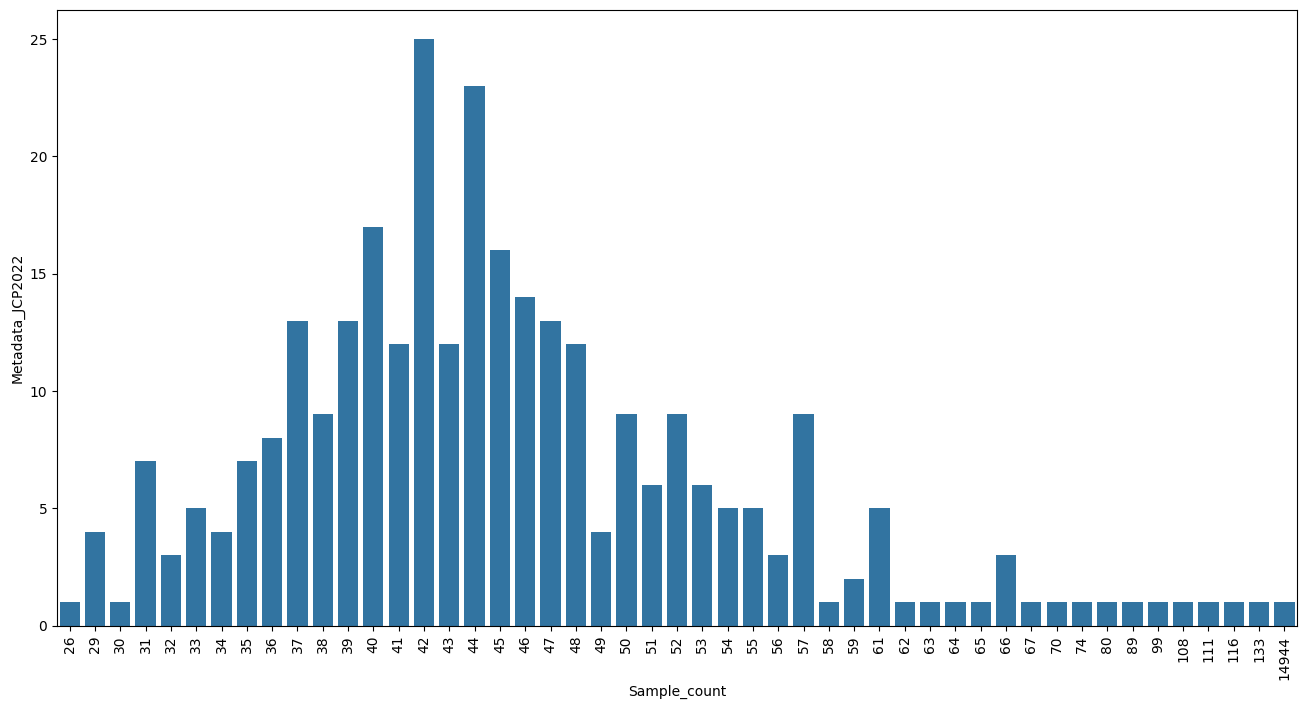

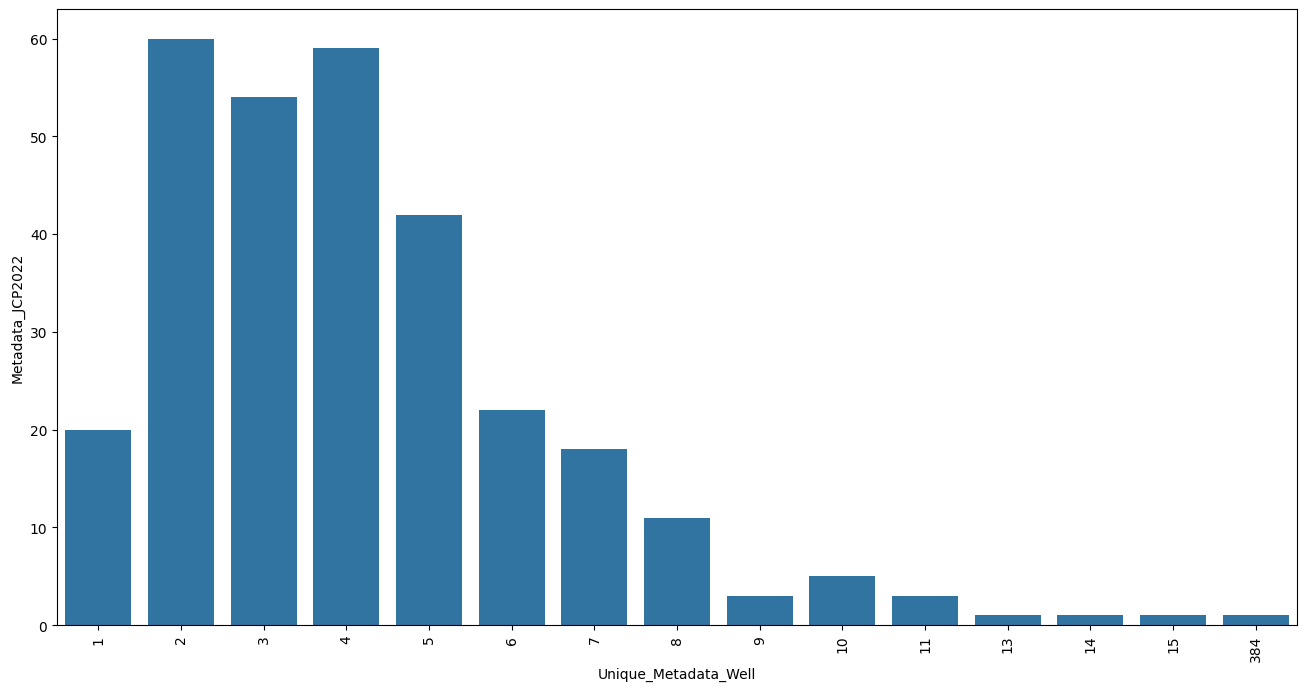

In [677]:
compounds_info_filtered2 = (merge_table_filtered2.group_by("Metadata_JCP2022")
                  .agg(pl.col("Metadata_InChIKey").count().alias("Sample_count"),
                       pl.col("Metadata_Source", "Metadata_Well", "Micro_id")
                       .n_unique().name.prefix("Unique_"))
                       )

fig, ax1 = plt.subplots(1, figsize=(16,8))

df_filtered2 = (compounds_info_filtered2.group_by("Sample_count")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Sample_count"))

sns.barplot(df_filtered2,
            x="Sample_count",
            y="Metadata_JCP2022",
            ax=ax1)
ax1.tick_params(axis='x', rotation=90)

fig, ax2 = plt.subplots(1, figsize=(16,8))

df2_filtered2 = (compounds_info_filtered2.group_by("Unique_Metadata_Well")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Unique_Metadata_Well"))

sns.barplot(df2_filtered2,
            x="Unique_Metadata_Well",
            y="Metadata_JCP2022",
            ax=ax2)
ax2.tick_params(axis='x', rotation=90)

Text(0.5, 1.0, 'Count of Unique Well per source per compound')

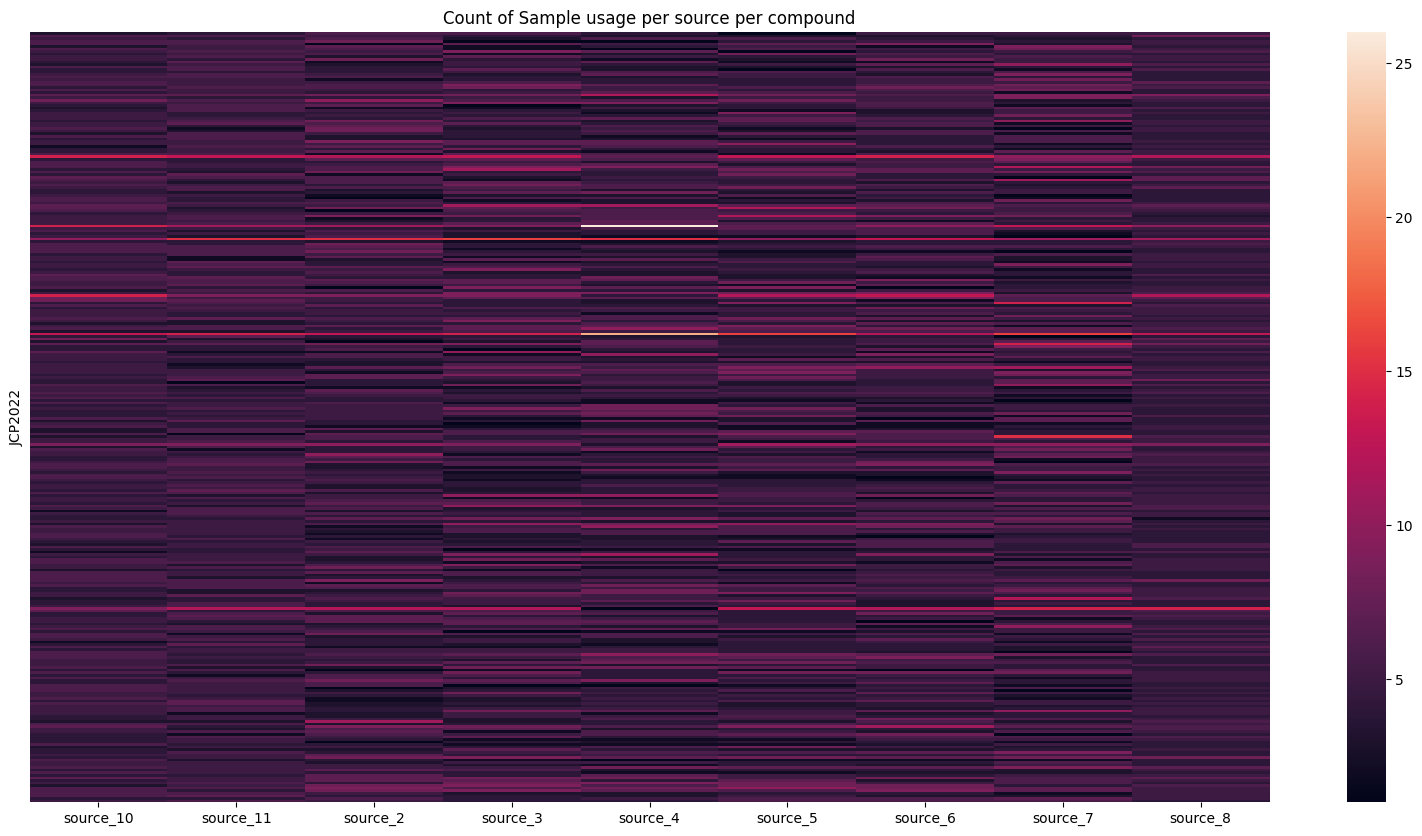

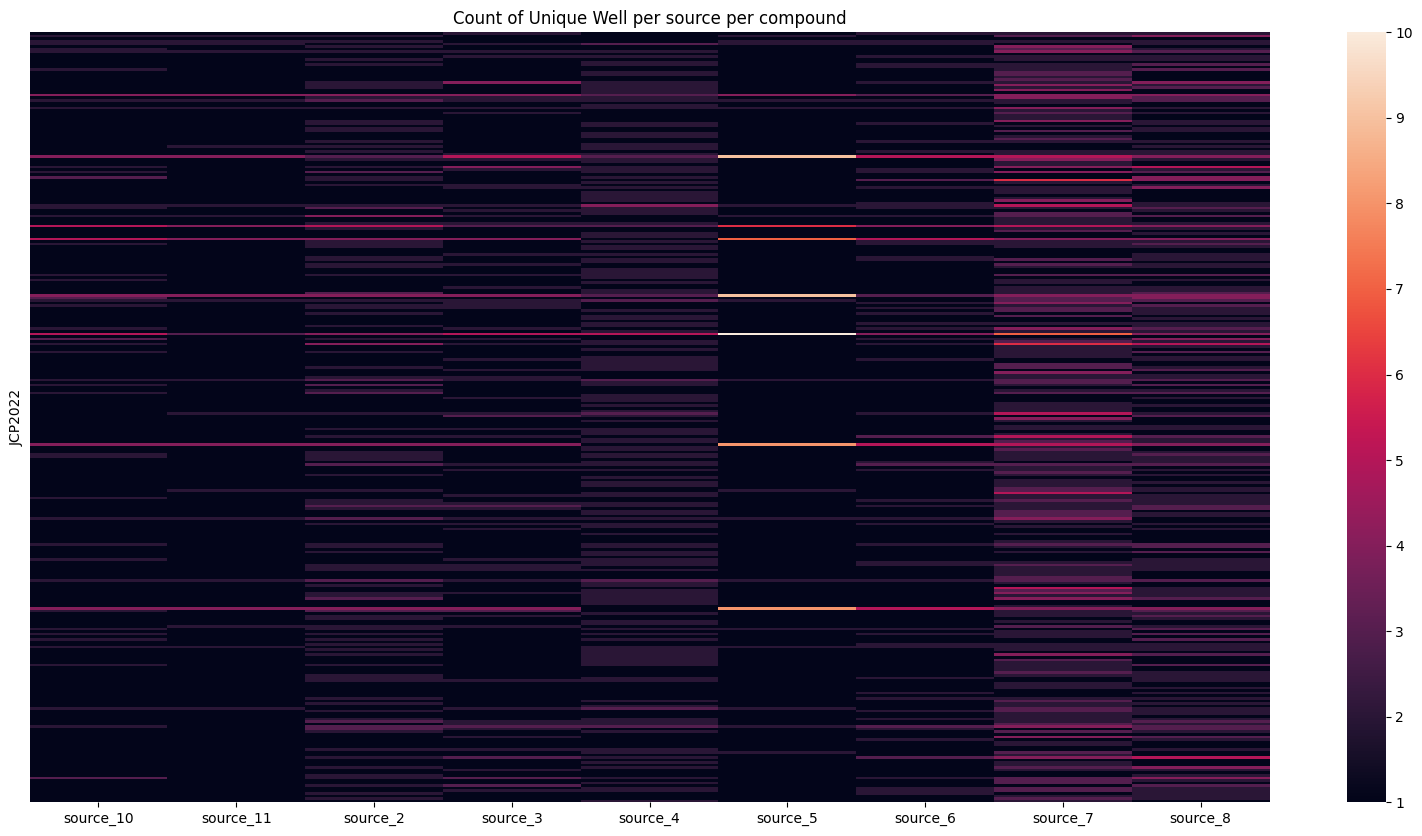

In [678]:
well_p_source_p_compound2 = (merge_table_filtered2.filter(pl.col("Metadata_JCP2022").is_in(controle_name) != True)
                            .group_by(["Metadata_JCP2022", "Metadata_Source"])
 .agg(pl.col("Metadata_JCP2022").count().alias("n_sample"),
      pl.col("Metadata_Well").n_unique().alias("n_well_unique"))
 .sort(by=["Metadata_JCP2022", "Metadata_Source"]))

count_sample_p_source_p_compound2 = well_p_source_p_compound2.pivot(index="Metadata_JCP2022",
                                                                 columns="Metadata_Source",
                                                                 values="n_sample")

unique_well_p_source_p_compound2 = well_p_source_p_compound2.pivot(index="Metadata_JCP2022",
                                                                 columns="Metadata_Source",
                                                                 values="n_well_unique")

fig1, ax1 = plt.subplots(1, figsize=(20,10))
sns.heatmap(count_sample_p_source_p_compound2.select(pl.all().exclude("Metadata_JCP2022")),
            ax=ax1)

ax1.set_xticklabels(count_sample_p_source_p_compound2.columns[1:])
ax1.tick_params(left = False, labelleft = False)
ax1.set_ylabel("JCP2022")
ax1.set_title("Count of Sample usage per source per compound")

fig2, ax2 = plt.subplots(1, figsize=(20,10))
sns.heatmap(unique_well_p_source_p_compound2.select(pl.all().exclude("Metadata_JCP2022")),
            ax=ax2)
           #robust=True)
ax2.set_xticklabels(unique_well_p_source_p_compound2.columns[1:])
ax2.tick_params(left = False, labelleft = False)
ax2.set_ylabel("JCP2022")
ax2.set_title("Count of Unique Well per source per compound")

In [679]:
merge_table_filtered2.shape

(28738, 20)

In [680]:
merge_table_filtered2.group_by("Metadata_Source").agg(pl.col("Metadata_JCP2022").n_unique())

Metadata_Source,Metadata_JCP2022
str,u32
"""source_7""",301
"""source_4""",301
"""source_11""",301
"""source_5""",301
"""source_8""",301
"""source_2""",301
"""source_3""",301
"""source_6""",301
"""source_10""",301


### j) Adding MOA

In [681]:
merge_table_filtered2 = merge_table_filtered2.with_columns(
    pl.when(pl.col("Metadata_JCP2022").str.contains("JCP2022_050797") &
    pl.col("pert_iname").str.contains("quinine"))
    .then(pl.lit("quinidine"))
    .otherwise(pl.col("pert_iname"))
    .alias("pert_iname"))

In [682]:
moa = pl.read_csv("https://s3.amazonaws.com/data.clue.io/repurposing/downloads/repurposing_drugs_20200324.txt",
            separator="\t",
            comment_prefix="!")

In [683]:
merge_table_filtered_moa = merge_table_filtered2.join(moa.select(
                                                      pl.col("pert_iname", "moa")),
                                                      on="pert_iname",
                                                      how="left")

Let's add the right pert_type and control type using the table from [broad_bable](https://github.com/broadinstitute/monorepo/blob/main/libs/jump_babel/tools/gen_database.py).

In [684]:
merge_table_filtered_moa.filter(
    pl.col("Metadata_JCP2022").is_in(["JCP2022_012818",
    "JCP2022_025848",
    "JCP2022_033924",
    "JCP2022_035095",
    "JCP2022_037716",
    "JCP2022_046054",
    "JCP2022_050797",
    "JCP2022_064022",
    "JCP2022_085227"])).select(
    pl.col("Metadata_JCP2022"),
    pl.col("pert_iname"),
    pl.col("pert_type"),
    pl.col("control_type"),
    pl.col("moa")).unique()

Metadata_JCP2022,pert_iname,pert_type,control_type,moa
str,str,str,str,str
"""JCP2022_050797…","""quinidine""","""trt""","""NA""","""sodium channel…"
"""JCP2022_035095…","""LY2109761""","""trt""","""NA""","""TGF beta recep…"
"""JCP2022_033924…","""DMSO""","""control""","""negcon""","""control vehicl…"
"""JCP2022_025848…","""dexamethasone""","""trt""","""NA""","""glucocorticoid…"
"""JCP2022_085227…","""aloxistatin""","""trt""","""NA""","""protease inhib…"
"""JCP2022_012818…","""TC-S-7004""","""control""","""poscon_cp""","""DYRK inhibitor…"
"""JCP2022_046054…","""FK-866""","""control""","""poscon_diverse…","""niacinamide ph…"
"""JCP2022_064022…","""NVS-PAK1-1""","""control""","""poscon_cp""","""p21 activated …"
"""JCP2022_037716…","""AMG900""","""control""","""poscon_cp""","""Aurora kinase …"


In [685]:
merge_table_filtered_moa = (merge_table_filtered_moa.with_columns(
pl.when(pl.col("Metadata_JCP2022").is_in(["JCP2022_025848", 
                                          "JCP2022_035095", 
                                          "JCP2022_050797", 
                                          "JCP2022_085227"]))
    .then(pl.lit("control"))
    .otherwise(pl.col("pert_type"))
    .alias("pert_type"),
pl.when(pl.col("Metadata_JCP2022").is_in(["JCP2022_025848", 
                                          "JCP2022_035095", 
                                          "JCP2022_050797", 
                                          "JCP2022_085227"]))
    .then(pl.lit("poscon"))
    .otherwise(pl.col("control_type"))
    .alias("control_type")))

#### Removing the samples without moa

In [686]:
merge_table_filtered_moa.filter(pl.col("moa").is_null()).select(
    pl.col("Metadata_JCP2022"),
    pl.col("pert_iname"),
    pl.col("pert_type"),
    pl.col("control_type"),
    pl.col("moa")).unique()

Metadata_JCP2022,pert_iname,pert_type,control_type,moa
str,str,str,str,str
"""JCP2022_096342…","""ML-323""","""control""","""poscon_cp""",null
"""JCP2022_001275…","""ML-193""","""trt""","""NA""",null
"""JCP2022_022359…","""GSK-37647""","""trt""","""NA""",null
"""JCP2022_068660…","""N-alpha-Methyl…","""trt""","""NA""",null
"""JCP2022_088224…","""carzenide""","""trt""","""NA""",null
"""JCP2022_048971…","""L-Cystine""","""trt""","""NA""",null
"""JCP2022_076573…","""epothilone-b""","""trt""","""NA""",null
"""JCP2022_069668…","""purvalanol-a""","""control""","""poscon_orf""",null
"""JCP2022_048928…","""trometamol""","""trt""","""NA""",null


In [687]:
merge_table_filtered_moa = merge_table_filtered_moa.filter(pl.col("moa").is_not_null())

#### Check if there is a unique set of keys which match the metadata keys to get features

The metadata which serves as a keys are: 

| Metadata_Source | Metadata_Plate | Metadata_Well | Metadata_JCP2022 |
|-----------------|----------------|---------------|------------------|

So it is important to verify that this set of keys uniquely identify the table. 

In [688]:
merge_table_filtered_moa = merge_table_filtered_moa.unique()

In [689]:
is_unique_id = (merge_table_filtered_moa.group_by(["Metadata_Source", "Metadata_Plate", 
                                  "Metadata_Well", "Metadata_JCP2022"])
 .agg(
     (pl.sum_horizontal(pl.all().exclude(["Metadata_Source", "Metadata_Plate", 
                                  "Metadata_Well", "Metadata_JCP2022"]).n_unique())
       + 4 - len(merge_table_filtered_moa.columns)).alias("n_multiple_value")))
is_unique_id.head()

Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,n_multiple_value
str,str,str,str,u32
"""source_5""","""APTJUM324""","""G23""","""JCP2022_033924…",0
"""source_5""","""ADMJUM014""","""D04""","""JCP2022_033924…",0
"""source_11""","""EC133-171LM2""","""E15""","""JCP2022_084963…",0
"""source_2""","""1086293560""","""N02""","""JCP2022_033924…",0
"""source_5""","""ADMJUM018""","""I06""","""JCP2022_033924…",0


In [690]:
is_unique_id.filter(
    pl.col("n_multiple_value") > 0)

Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,n_multiple_value
str,str,str,str,u32


### k) Exporting into a csv file

#### Quick info on the final table

In [700]:
merge_table_filtered_moa.group_by("control_type").agg(pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
                                                         pl.col("Metadata_JCP2022").count().alias("n_sample"))

control_type,n_compound,n_sample
str,u32,u32
"""NA""",235,10332
"""negcon""",1,14944
"""poscon_diverse…",14,767
"""poscon_cp""",24,1211
"""poscon""",4,451
"""poscon_orf""",5,211


Apparently there is more poscon than the 8 poscon + 1 negcon stated in [broad_bable](https://github.com/broadinstitute/monorepo/blob/main/libs/jump_babel/tools/gen_database.py):
* "JCP2022_012818": "poscon",  # "TC-S-7004",
* "JCP2022_025848": "poscon",  # "Dexamethasone",
* "JCP2022_033924": "negcon",  # "DMSO",
* "JCP2022_035095": "poscon",  # "LY2109761",
* "JCP2022_037716": "poscon",  # "AMG900",
* "JCP2022_046054": "poscon",  # "FK-866",
* "JCP2022_050797": "poscon",  # "Quinidine",
* "JCP2022_064022": "poscon",  # "NVS-PAK1-1",
* "JCP2022_085227": "poscon",  # "Aloxistatin",

It looks like that some compound treatment are poscon for a specific experiment so it does increase the number of control. 

In [699]:
merge_table_filtered_moa.with_columns(
    pl.when(pl.col("control_type").str.contains("poscon"))
    .then(pl.lit("poscon"))
    .otherwise(pl.col("control_type"))
    .alias("control_type")).group_by("control_type").agg(pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
                                                         pl.col("Metadata_JCP2022").count().alias("n_sample"))

control_type,n_compound,n_sample
str,u32,u32
"""poscon""",47,2640
"""NA""",235,10332
"""negcon""",1,14944


In [694]:
merge_table_filtered_moa.write_csv("target2_metadata")